#ABDELLI KHALID

#🧩 1. Introduction & Objectif :

#Ce projet a été réalisé dans le cadre du Master 2 Proba–Stat des Nouvelles Données à l’Université Gustave Eiffel (année universitaire 2024–2025).

# 📌 L’objectif principal était de prédire la fréquence (FREQ) et le coût moyen (CM) des sinistres clients, puis d’en déduire la charge totale. Grâce à des modèles de régression adaptés (notamment XGBoost avec fonction de perte de type Tweedie), des techniques de sur-échantillonnage, ainsi que du clustering client (KMeans) sur la charge prédite, nous avons pu :

#Obtenir des prédictions pertinentes, malgré un déséquilibre fort (90% des sinistres à zéro),

#Segmenter les clients selon leur niveau de risque (charge),

#Visualiser les clusters via des graphiques 3D intuitifs et interprétables,


## Présente le contexte : Crédit Agricole Assurances, contrat multirisque agricole


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 📦 Chargement des bibliothèques nécessaires


In [2]:
# pandas : pour la manipulation de tableaux de données
import pandas as pd

# matplotlib : bibliothèque de base pour les graphiques
import matplotlib.pyplot as plt

# numpy : bibliothèque pour le calcul numérique
import numpy as np

# seaborn : bibliothèque de visualisation avancée basée sur matplotlib, utile pour des graphes plus esthétiques
import seaborn as sns

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import classification_report, accuracy_score # classification_report, accuracy_score pour évaluer la performance du modèle.

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import PoissonRegressor, TweedieRegressor



 # Chargement des données d'entraînement

In [ ]:
#  Chargement du fichier train_x.csv depuis Google Drive
df_train_x = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/train_x.csv',

    #  Remplacement des valeurs manquantes : on considère ces chaînes comme des valeurs nulles
    na_values=["", " ", "NA", "??", "-", "--", "nan"]
)

<ipython-input-173-2457028908>:1: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_x = pd.read_csv(


# 🧹 Analyse des colonnes numériques contenant des valeurs manquantes


In [ ]:
# Sélection de toutes les colonnes de type numérique (int, float)
df_train_x_num = df_train_x.select_dtypes(include=['number'])
# Boucle sur chaque colonne numérique

for col in df_train_x_num.columns  :
    #  Si la colonne contient des valeurs manquantes, on l’affiche
    if df_train_x_num[col].isnull().sum()>0 :
    print(f"colonne {col}, avec nombre de valeurs manquantes=  {df_train_x_num[col].isnull().sum()}")

#  Fonction de remplissage des colonnes numériques manquantes avec XGBoost (approche classification)

In [ ]:
def fill_missing_xgb_numeric(df, target_col, under_factor=10):
    from sklearn.utils import shuffle # shuffle pour mélanger les données équilibrées

    print(f"\n Traitement de la colonne : {target_col}")
    # On isole les lignes qu’on utilisera pour entraîner (non-NaN) et celles à prédire (NaN)
    df_notna = df[df[target_col].notna()]
    df_nan = df[df[target_col].isna()]

    #Puisqu'on utilise un classifieur (XGBoostClassifier), on convertit les valeurs numériques continues en classes entières
    #value_mapping transforme une valeur réelle (ex. 12.3) en classe (ex. 0)
    #inverse_mapping permet de revenir à la valeur réelle une fois les prédictions faites

    original_values = sorted(df_notna[target_col].unique())
    value_mapping = {v: i for i, v in enumerate(original_values)}
    inverse_mapping = {i: v for v, i in value_mapping.items()}
    df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)

    # On identifie la classe majoritaire pour éviter un déséquilibre qui fausserait le modèle
    class_counts = df_notna['target_mapped'].value_counts()
    majority_class = class_counts.idxmax()
    minority_classes = [c for c in class_counts.index if c != majority_class]
    # On garde toutes les classes minoritaires mais on réduit la taille de la classe majoritaire pour équilibrer le jeu d’entraînement

    df_majority = df_notna[df_notna['target_mapped'] == majority_class]
    df_minority = df_notna[df_notna['target_mapped'].isin(minority_classes)]

    # Sous-échantillonnage majoritaire
    df_majority_under = df_majority.sample(
        min(len(df_minority) * under_factor, len(df_majority)),
        random_state=42
    )
    #Fusion des deux groupes (majorité réduite + minorités), puis mélange aléatoire

    df_train_balanced = pd.concat([df_majority_under, df_minority])
    df_train_balanced = shuffle(df_train_balanced, random_state=42)

    # Les classes majoritaires reçoivent un poids plus élevé pour compenser le sous-échantillonnage
    weights = np.where(
        df_train_balanced['target_mapped'] == majority_class,
        under_factor,
        1.0
    )

    # Données
    X_train = df_train_balanced.drop(columns=[target_col, 'target_mapped'])
    y_train = df_train_balanced['target_mapped']

    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype('category')

    model = XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        enable_categorical=True
    )
    model.fit(X_train, y_train, sample_weight=weights)

    # Prédiction sur les NaNs
    X_nan = df_nan.drop(columns=[target_col])
    X_nan = X_nan.reindex(columns=X_train.columns, fill_value=0)

    for col in X_nan.columns:
        if X_nan[col].dtype == 'object':
            X_nan[col] = X_nan[col].astype('category').cat.set_categories(X_train[col].cat.categories)

    predicted_nan_mapped = model.predict(X_nan)
    predicted_nan_values = pd.Series(predicted_nan_mapped).map(inverse_mapping)

    # Injection
    df.loc[df[target_col].isna(), target_col] = predicted_nan_values.values

    # Évaluation
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train))
    print(" Accuracy :", accuracy_score(y_train, y_pred_train))


# 📌 CARACT2

In [ ]:
fill_missing_xgb_numeric(df_train_x, 'CARACT2')



⚙️ Traitement de la colonne : CARACT2


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2920
           1       1.00      1.00      1.00       292

    accuracy                           1.00      3212
   macro avg       1.00      1.00      1.00      3212
weighted avg       1.00      1.00      1.00      3212

✅ Accuracy : 1.0


# 📌 KAPITAL


In [ ]:
kapital_cols = [
    'KAPITAL11', 'KAPITAL15', 'KAPITAL16', 'KAPITAL17', 'KAPITAL18', 'KAPITAL19',
    'KAPITAL20', 'KAPITAL21', 'KAPITAL22', 'KAPITAL23', 'KAPITAL24',
    'KAPITAL29', 'KAPITAL30', 'KAPITAL31', 'KAPITAL33'
]

for col in kapital_cols:
    fill_missing_xgb_numeric(df_train_x, col)



⚙️ Traitement de la colonne : KAPITAL11


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111351
           1       1.00      1.00      1.00     10285
           2       1.00      1.00      1.00      8398
           3       1.00      1.00      1.00     14367
           4       1.00      1.00      1.00     19676
           5       1.00      1.00      1.00     12660
           6       1.00      1.00      1.00     22448
           7       1.00      1.00      1.00     16698
           8       1.00      1.00      1.00     12664
           9       1.00      1.00      1.00      8458
          10       1.00      1.00      1.00     11022
          11       1.00      1.00      1.00      5622
          12       1.00      1.00      1.00     10956

    accuracy                           1.00    264605
   macro avg       1.00      1.00      1.00    264605
weighted avg       1.00      1.00      1.00    264605

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL15


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24500
           1       1.00      1.00      1.00       582
           2       1.00      1.00      1.00       873
           3       1.00      1.00      1.00       558
           4       1.00      1.00      1.00       138
           5       1.00      1.00      1.00       299

    accuracy                           1.00     26950
   macro avg       1.00      1.00      1.00     26950
weighted avg       1.00      1.00      1.00     26950

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL16


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54590
           1       1.00      1.00      1.00       785
           2       1.00      0.96      0.98      1271
           3       1.00      0.97      0.99      1276
           4       1.00      1.00      1.00       614
           5       1.00      0.99      0.99      1513

    accuracy                           1.00     60049
   macro avg       1.00      0.99      0.99     60049
weighted avg       1.00      1.00      1.00     60049

✅ Accuracy : 0.9982014688004797

⚙️ Traitement de la colonne : KAPITAL17


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34190
           1       1.00      1.00      1.00       448
           2       1.00      1.00      1.00      1097
           3       1.00      1.00      1.00       948
           4       1.00      1.00      1.00       246
           5       1.00      1.00      1.00       680

    accuracy                           1.00     37609
   macro avg       1.00      1.00      1.00     37609
weighted avg       1.00      1.00      1.00     37609

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL18


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16160
           1       1.00      1.00      1.00       696
           2       1.00      1.00      1.00       721
           3       1.00      1.00      1.00       133
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        50

    accuracy                           1.00     17776
   macro avg       1.00      1.00      1.00     17776
weighted avg       1.00      1.00      1.00     17776

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL19


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57810
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       718
           3       1.00      1.00      1.00       758
           4       1.00      1.00      1.00       275
           5       1.00      0.99      0.99      2093
           6       1.00      1.00      1.00       149
           7       1.00      1.00      1.00        64
           8       1.00      1.00      1.00       156
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00      1334

    accuracy                           1.00     63591
   macro avg       1.00      1.00      1.00     63591
weighted avg       1.00      1.00      1.00     63591

✅ Accuracy : 0.9996068626063437

⚙️ Traitement de la colonne : KAPITAL20


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15270
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       577
           3       1.00      1.00      1.00       348
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00       215

    accuracy                           1.00     16797
   macro avg       1.00      1.00      1.00     16797
weighted avg       1.00      1.00      1.00     16797

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL21


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    220079
           1       0.96      0.65      0.77      3391
           2       0.70      0.67      0.68     16363
           3       0.65      0.65      0.65     29482
           4       0.87      0.38      0.53     14043
           5       0.58      0.87      0.69     49141
           6       0.87      0.50      0.64     10612
           7       0.95      0.50      0.66      6489
           8       0.77      0.59      0.67     16184
           9       1.00      0.95      0.97       510
          10       0.87      0.59      0.71     11943

    accuracy                           0.86    378237
   macro avg       0.84      0.67      0.72    378237
weighted avg       0.88      0.86      0.86    378237

✅ Accuracy : 0.8619965788645744

⚙️ Traitement de la colonne : KAPITAL22


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24640
           1       1.00      1.00      1.00       156
           2       1.00      0.98      0.99       371
           3       1.00      0.97      0.99       329
           4       1.00      1.00      1.00       140
           5       1.00      0.97      0.99       514
           6       1.00      1.00      1.00       158
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00       201
           9       1.00      1.00      1.00        36
          10       1.00      0.96      0.98       522

    accuracy                           1.00     27104
   macro avg       1.00      0.99      0.99     27104
weighted avg       1.00      1.00      1.00     27104

✅ Accuracy : 0.9980445690672963

⚙️ Traitement de la colonne : KAPITAL23


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    320186
           1       0.83      0.89      0.86     16757
           2       0.79      0.83      0.81     18102
           3       0.84      0.76      0.80     11086
           4       0.97      0.74      0.84      4181
           5       0.84      0.86      0.85      6533
           6       0.98      0.85      0.91      1974
           7       1.00      0.96      0.98       741
           8       0.99      0.91      0.95      1107
           9       1.00      1.00      1.00       296
          10       0.99      0.97      0.98      1486

    accuracy                           0.97    382449
   macro avg       0.93      0.89      0.91    382449
weighted avg       0.97      0.97      0.97    382449

✅ Accuracy : 0.9736147826246114

⚙️ Traitement de la colonne : KAPITAL24


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    347648
           1       0.91      0.95      0.93     18850
           2       0.91      0.85      0.88     10743
           3       0.98      0.82      0.90      3531
           4       0.99      0.93      0.96      1140
           5       1.00      0.97      0.98       864

    accuracy                           0.99    382776
   macro avg       0.97      0.92      0.94    382776
weighted avg       0.99      0.99      0.99    382776

✅ Accuracy : 0.9914675946245324

⚙️ Traitement de la colonne : KAPITAL29


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24970
           1       1.00      1.00      1.00      1542
           2       1.00      1.00      1.00       955

    accuracy                           1.00     27467
   macro avg       1.00      1.00      1.00     27467
weighted avg       1.00      1.00      1.00     27467

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL30


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17560
           1       1.00      1.00      1.00       999
           2       1.00      1.00      1.00       757

    accuracy                           1.00     19316
   macro avg       1.00      1.00      1.00     19316
weighted avg       1.00      1.00      1.00     19316

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL31


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71490
           1       1.00      0.98      0.99      5748
           2       1.00      1.00      1.00      1401

    accuracy                           1.00     78639
   macro avg       1.00      0.99      1.00     78639
weighted avg       1.00      1.00      1.00     78639

✅ Accuracy : 0.9984104579152837

⚙️ Traitement de la colonne : KAPITAL33


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    175060
           1       1.00      0.62      0.76      2268
           2       0.98      0.83      0.90      1014
           3       0.98      0.83      0.90      1403
           4       0.98      0.89      0.93      1830
           5       0.99      0.94      0.97       890
           6       0.97      0.95      0.96      1856
           7       0.98      0.95      0.96      1422
           8       0.98      0.97      0.98      1994
           9       0.99      1.00      0.99      4829

    accuracy                           0.99    192566
   macro avg       0.98      0.90      0.94    192566
weighted avg       0.99      0.99      0.99    192566

✅ Accuracy : 0.9908706625260949


# 📌 SURFACE

In [ ]:
surface_cols = [
     'SURFACE3','SURFACE7', 'SURFACE8', 'SURFACE9',
    'SURFACE10', 'SURFACE11', 'SURFACE18', 'SURFACE19'
]

for col in surface_cols:
    fill_missing_xgb_numeric(df_train_x, col)



⚙️ Traitement de la colonne : SURFACE3


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18887
           1       0.96      0.94      0.95      3662
           2       0.97      0.96      0.97      6078
           3       0.88      0.88      0.88      7461
           4       0.93      0.94      0.94      4437
           5       0.93      0.92      0.93      3673
           6       0.95      0.94      0.94      4802
           7       0.94      0.93      0.93      3924
           8       0.94      0.95      0.94      4383
           9       0.95      0.95      0.95      3992
          10       0.96      0.95      0.95      4387
          11       0.93      0.93      0.93      3758
          12       0.95      0.94      0.95      4078
          13       0.95      0.94      0.94      3859
          14       0.95      0.94      0.94      4185
          15       0.94      0.93      0.93      3549
          16       0.91      0.91      0.91      3783
          17       0.93    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.82      1.00      0.90    214468
           1       0.93      0.45      0.61     93703
           2       0.84      0.86      0.85     35735
           3       0.90      0.93      0.91     18409
           4       0.94      0.94      0.94      5492
           5       0.97      0.98      0.98      3328
           6       0.99      1.00      0.99      2913
           7       1.00      1.00      1.00      1513
           8       1.00      1.00      1.00      1170
           9       1.00      1.00      1.00       796
          10       1.00      1.00      1.00       617
          11       1.00      1.00      1.00       396
          12       1.00      1.00      1.00       323
          13       1.00      1.00      1.00       190
          14       1.00      1.00      1.00       142
          15       1.00      1.00      1.00        82
          16       1.00      1.00      1.00        66
          17       1.00    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    231230
           1       1.00      1.00      1.00       361
           2       1.00      1.00      1.00       509
           3       1.00      1.00      1.00       484
           4       1.00      1.00      1.00       194
           5       1.00      1.00      1.00       183
           6       1.00      1.00      1.00       246
           7       1.00      1.00      1.00       255
           8       1.00      1.00      1.00       221
           9       1.00      1.00      1.00       225
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       277
          12       1.00      1.00      1.00       350
          13       1.00      1.00      1.00       307
          14       1.00      1.00      1.00       465
          15       1.00      1.00      1.00       366
          16       1.00      1.00      1.00       437
          17       1.00    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97    128760
           1       1.00      0.35      0.52     12804
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4

    accuracy                           0.94    141636
   macro avg       0.99      0.92      0.94    141636
weighted avg       0.94      0.94      0.93    141636

✅ Accuracy : 0.941151967014036

⚙️ Traitement de la colonne : SURFACE10


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      0.57      0.72     31358
           1       0.84      1.00      0.91    200956
           2       0.90      0.61      0.72     68966
           3       0.87      0.85      0.86     37655
           4       0.88      0.85      0.87     11546
           5       0.98      0.91      0.94      7060
           6       0.98      0.96      0.97      5610
           7       1.00      0.98      0.99      3441
           8       1.00      1.00      1.00      2808
           9       1.00      1.00      1.00      1593
          10       1.00      1.00      1.00      1427
          11       1.00      1.00      1.00       881
          12       1.00      1.00      1.00       730
          13       1.00      1.00      1.00       457
          14       1.00      1.00      1.00       399
          15       1.00      1.00      1.00       242
          16       1.00      1.00      1.00       190
          17       1.00    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25298
           1       1.00      1.00      1.00      4899
           2       1.00      1.00      1.00      7327
           3       1.00      1.00      1.00      8934
           4       1.00      1.00      1.00      5084
           5       1.00      1.00      1.00      4345
           6       1.00      1.00      1.00      5390
           7       1.00      1.00      1.00      4582
           8       1.00      1.00      1.00      4941
           9       1.00      1.00      1.00      4442
          10       1.00      1.00      1.00      4826
          11       1.00      1.00      1.00      4105
          12       1.00      1.00      1.00      4512
          13       1.00      1.00      1.00      4132
          14       1.00      1.00      1.00      4664
          15       1.00      1.00      1.00      3712
          16       1.00      1.00      1.00      4051
          17       1.00    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98    225092
           1       0.66      0.45      0.54     21288
           2       0.73      0.66      0.69     12900
           3       0.92      0.85      0.88      8097
           4       1.00      1.00      1.00      5631
           5       1.00      1.00      1.00      4011
           6       0.99      1.00      0.99      3076
           7       1.00      1.00      1.00      2179
           8       1.00      1.00      1.00      1781
           9       1.00      1.00      1.00      1358
          10       1.00      1.00      1.00      1246
          11       1.00      1.00      1.00       895
          12       1.00      1.00      1.00       840
          13       0.99      1.00      0.99       670
          14       1.00      0.99      1.00       579
          15       1.00      1.00      1.00       451
          16       0.98      0.98      0.98       454
          17       0.98    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86140
           1       1.00      1.00      1.00       437
           2       1.00      1.00      1.00       501
           3       1.00      1.00      1.00       485
           4       1.00      1.00      1.00       373
           5       1.00      1.00      1.00       416
           6       1.00      1.00      1.00       319
           7       1.00      1.00      1.00       301
           8       1.00      1.00      1.00       210
           9       1.00      1.00      1.00       303
          10       1.00      1.00      1.00       234
          11       1.00      1.00      1.00      5035

    accuracy                           1.00     94754
   macro avg       1.00      1.00      1.00     94754
weighted avg       1.00      1.00      1.00     94754

✅ Accuracy : 1.0


#📌 RISK

In [ ]:
risk_cols = ['RISK1', 'RISK2', 'RISK3', 'RISK4', 'RISK5', 'RISK7']


for col in risk_cols:
    fill_missing_xgb_numeric(df_train_x, col)



⚙️ Traitement de la colonne : RISK1


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       265
           2       0.98      0.97      0.97      3182
           3       0.90      0.83      0.86     61785
           4       0.89      0.95      0.92    120939
           5       0.90      0.72      0.80     10639
           6       0.99      0.89      0.94       785
           7       1.00      1.00      1.00       212
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00    159204

    accuracy                           0.94    357037
   macro avg       0.97      0.94      0.95    357037
weighted avg       0.94      0.94      0.94    357037

✅ Accuracy : 0.9438237493593101

⚙️ Traitement de la colonne : RISK2


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00       152
           9       1.00      1.00      1.00       235
          10       1.00      1.00      1.00       375
          11       1.00      1.00      1.00       537
          12       1.00      1.00      1.00       704
          13       0.99      1.00      0.99      1134
          14       0.95      0.98      0.96      1684
          15       0.93      0.95      0.94      2427
          16       0.87      0.92      0.89      3550
          17       0.85    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        56
           4       1.00      1.00      1.00       133
           5       1.00      1.00      1.00       303
           6       1.00      1.00      1.00       892
           7       0.99      0.98      0.98      1933
           8       0.94      0.92      0.93      5960
           9       0.85      0.86      0.86     11117
          10       0.81      0.77      0.79     15896
          11       0.78      0.76      0.77     29701
          12       0.70      0.73      0.71     33529
          13       0.68      0.68      0.68     29720
          14       0.70      0.70      0.70     25693
          15       0.72      0.75      0.73     18135
          16       0.80      0.78      0.79     10910
          17       0.85    

<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       466
           1       0.89      0.68      0.77     31050
           2       0.77      0.90      0.83     93994
           3       0.72      0.66      0.69     48625
           4       0.81      0.66      0.73     18104
           5       0.95      0.80      0.87      4606
           6       0.99      0.98      0.99       898
           7       1.00      1.00      1.00        78
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00    159204

    accuracy                           0.88    357037
   macro avg       0.93      0.89      0.90    357037
weighted avg       0.88      0.88      0.88    357037

✅ Accuracy : 0.8790965642216353

⚙️ Traitement de la colonne : RISK5


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2257
           1       0.99      0.98      0.99      2944
           2       0.97      0.88      0.93      3920
           3       0.97      0.80      0.88      2731
           4       0.85      0.93      0.89     99501
           5       0.81      0.78      0.79     71314
           6       0.87      0.59      0.70     14805
           7       1.00      1.00      1.00       311
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        39
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00    159204

    accuracy                           0.91    357037
   macro avg       0.96      0.91      0.93    357037
weighted avg       0.92      0.91      0.91    357037

✅ Accuracy : 0.9148911737438977

⚙️ Traitement de la colonne : RISK7


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     43219
           1       0.95      0.92      0.93     16132
           2       0.89      0.94      0.91     18216
           3       0.97      0.95      0.96     78111
           4       0.96      0.91      0.93     11028
           5       0.99      1.00      1.00    190329
           6       1.00      1.00      1.00         2

    accuracy                           0.98    357037
   macro avg       0.96      0.96      0.96    357037
weighted avg       0.98      0.98      0.98    357037

✅ Accuracy : 0.9786408691536171


# 📌 ZONE_VENT


In [ ]:
fill_missing_xgb_numeric(df_train_x, 'ZONE_VENT')



⚙️ Traitement de la colonne : ZONE_VENT


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.99      0.92      0.96     86592
           1       0.95      1.00      0.98    218973
           2       1.00      0.92      0.96     59463

    accuracy                           0.97    365028
   macro avg       0.98      0.95      0.96    365028
weighted avg       0.97      0.97      0.97    365028

✅ Accuracy : 0.9686900730902834


# 📌 DUREE_REQANEUF


In [ ]:
fill_missing_xgb_numeric(df_train_x, 'DUREE_REQANEUF')



⚙️ Traitement de la colonne : DUREE_REQANEUF


<ipython-input-176-661412019>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9096
           1       1.00      1.00      1.00    260050
           2       1.00      1.00      1.00      9100
           3       1.00      1.00      1.00      7809

    accuracy                           1.00    286055
   macro avg       1.00      1.00      1.00    286055
weighted avg       1.00      1.00      1.00    286055

✅ Accuracy : 1.0


#  Identification des colonnes catégorielles contenant des valeurs manquantes

In [ ]:
df_train_x_cat = df_train_x.select_dtypes(include=['object'])
for col in df_train_x_cat.columns  :
  if df_train_x_cat[col].isnull().sum()>0 :
    print(f"colonne {col}, avec nombre de valeurs manquantes=  {df_train_x_cat[col].isnull().sum()}")

colonne DEROG14, avec nombre de valeurs manquantes=  383602
colonne DISTANCE_244, avec nombre de valeurs manquantes=  218590
colonne IND_Y1_Y2, avec nombre de valeurs manquantes=  18590
colonne IND_INC, avec nombre de valeurs manquantes=  18590


# Fonction de remplissage des colonnes catégorielles manquantes avec XGBoost (approche classification)

In [ ]:
def fill_missing_xgb_cat(df, target_col, under_factor=10):

    from sklearn.utils import shuffle

    print(f"\n Traitement de la colonne : {target_col}")

    df_notna = df[df[target_col].notna()].copy()
    df_nan = df[df[target_col].isna()].copy()
    if df_notna.empty:
        print(f" La colonne {target_col} ne contient aucune valeur non nulle. Aucun traitement effectué.")
        return df
    original_values = sorted(df_notna[target_col].unique())
    value_mapping = {v: i for i, v in enumerate(original_values)}
    inverse_mapping = {i: v for v, i in value_mapping.items()}
    df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)

    class_counts = df_notna['target_mapped'].value_counts()
    majority_class = class_counts.idxmax()
    minority_classes = [c for c in class_counts.index if c != majority_class]

    df_majority = df_notna[df_notna['target_mapped'] == majority_class]
    df_minority = df_notna[df_notna['target_mapped'].isin(minority_classes)]

    df_majority_under = df_majority.sample(
        n=min(len(df_minority) * under_factor, len(df_majority)),
        random_state=42
    )

    df_train = pd.concat([df_majority_under, df_minority])
    df_train = shuffle(df_train, random_state=42)

    weights = np.where(
        df_train['target_mapped'] == majority_class,
        under_factor,
        1.0
    )

    X_train = df_train.drop(columns=[target_col, 'target_mapped'])
    y_train = df_train['target_mapped']

    for col in X_train.select_dtypes(include='object').columns:
        X_train[col] = X_train[col].astype('category')

    model = XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        enable_categorical=True
    )

    model.fit(X_train, y_train, sample_weight=weights)

    X_nan = df_nan.drop(columns=[target_col])
    X_nan = X_nan.reindex(columns=X_train.columns, fill_value=0)

    for col in X_nan.columns:
        if X_nan[col].dtype == 'object':
            X_nan[col] = X_nan[col].astype('category')
            if col in X_train.columns:
                X_nan[col] = X_nan[col].cat.set_categories(X_train[col].cat.categories)

    pred_nan = model.predict(X_nan)
    pred_nan_values = pd.Series(pred_nan).map(inverse_mapping)

    df.loc[df[target_col].isna(), target_col] = pred_nan_values.values

    y_pred_train = model.predict(X_train)
    print(" Rapport de classification :")
    print(classification_report(y_train, y_pred_train))
    print("Accuracy :", accuracy_score(y_train, y_pred_train))

    return df


# Imputation des colonnes catégorielles avec (RandomForestClassifier)

In [ ]:
colonnes_categorielle = ['IND_INC','IND_Y1_Y2','DEROG14','DISTANCE_244']
colonnes_numeriques = df_train_x.select_dtypes(include=['number']).columns
colonnes_numeriques = [col for col in colonnes_numeriques if "_missing" not in col]

for col in colonnes_categorielle:
    print(f"\n Traitement de la colonne : {col}")

    df_non_missing = df_train_x[df_train_x[col].notna()].copy()
    df_missing = df_train_x[df_train_x[col].isna()].copy()

    X = df_non_missing[colonnes_numeriques]
    y = df_non_missing[col].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy pour {col} : {acc:.4f}")




    if not df_missing.empty:
        X_missing = df_missing[colonnes_numeriques]
        y_pred_missing = model.predict(X_missing)

        df_train_x.loc[df_missing.index, col] = y_pred_missing
        print(f" {col} imputée avec succès.")
    else:
        print(f"Aucune valeur manquante à imputer pour {col}.")



 Traitement de la colonne : IND_INC
Accuracy pour IND_INC : 1.0000
 IND_INC imputée avec succès.

 Traitement de la colonne : IND_Y1_Y2
Accuracy pour IND_Y1_Y2 : 1.0000
 IND_Y1_Y2 imputée avec succès.

 Traitement de la colonne : DEROG14
Accuracy pour DEROG14 : 1.0000
 DEROG14 imputée avec succès.

 Traitement de la colonne : DISTANCE_244
Accuracy pour DISTANCE_244 : 1.0000
 DISTANCE_244 imputée avec succès.


In [ ]:
distance_cols =['DISTANCE_111', 'DISTANCE_112', 'DISTANCE_121', 'DISTANCE_122', 'DISTANCE_123', 'DISTANCE_124', 'DISTANCE_131', 'DISTANCE_132', 'DISTANCE_133',
                  'DISTANCE_141', 'DISTANCE_142', 'DISTANCE_212', 'DISTANCE_213', 'DISTANCE_221', 'DISTANCE_222', 'DISTANCE_223', 'DISTANCE_242', 'DISTANCE_243', 'DISTANCE_321',
                  'DISTANCE_322', 'DISTANCE_323', 'DISTANCE_331', 'DISTANCE_332', 'DISTANCE_333', 'DISTANCE_334', 'DISTANCE_335', 'DISTANCE_411', 'DISTANCE_412', 'DISTANCE_421',
                  'DISTANCE_422', 'DISTANCE_423', 'DISTANCE_511', 'DISTANCE_512', 'DISTANCE_521', 'DISTANCE_522', 'DISTANCE_523',
                  'DISTANCE_211','DISTANCE_231','DISTANCE_324','DISTANCE_2','DISTANCE_313','DISTANCE_312','DISTANCE_311','DISTANCE_1']


for col in distance_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)


⚙️ Traitement de la colonne : DISTANCE_111
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     73825
           1       0.97      0.72      0.83     63422
           2       0.96      0.94      0.95     28650
           3       1.00      1.00      1.00         1

    accuracy                           0.88    165898
   macro avg       0.94      0.92      0.92    165898
weighted avg       0.90      0.88      0.88    165898

✅ Accuracy : 0.8829220364320245

⚙️ Traitement de la colonne : DISTANCE_112
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.69      1.00      0.82     97413
           1       0.95      0.26      0.40     54644
           2       0.91      0.72      0.81     13840
           3       1.00      1.00      1.00         1

    accuracy                           0.73    165898
   macro avg       0.89      0.74      0.76    165898
weigh

In [ ]:
Propos_cols = ['PROPORTION_11', 'PROPORTION_12', 'PROPORTION_13', 'PROPORTION_14',
'PROPORTION_22', 'PROPORTION_32', 'PROPORTION_33','PROPORTION_21',
'PROPORTION_41', 'PROPORTION_42', 'PROPORTION_51', 'PROPORTION_52','PROPORTION_23', 'PROPORTION_24', 'PROPORTION_31']


for col in Propos_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)


⚙️ Traitement de la colonne : DISTANCE_1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.44      0.62     66279
           1       0.54      1.00      0.70     68865
           2       1.00      0.28      0.44     30753
           3       1.00      1.00      1.00         1

    accuracy                           0.65    165898
   macro avg       0.88      0.68      0.69    165898
weighted avg       0.81      0.65      0.62    165898

✅ Accuracy : 0.6453483465744011

⚙️ Traitement de la colonne : PROPORTION_11
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    319870
           1       0.99      0.71      0.83     31668
           2       0.99      0.94      0.97      8987
           3       1.00      0.99      0.99      2490
           4       1.00      1.00      1.00      1087
           5       1.00      1.00      1.00       553
       

#📌 Groupe 3 : Indicateurs NBJTX*


In [ ]:
NBJTX_cols = ['NBJTX25_MM_A', 'NBJTX25_MMAX_A', 'NBJTX25_MSOM_A',
    'NBJTX0_MM_A', 'NBJTX0_MMAX_A', 'NBJTX0_MSOM_A',
    'NBJTXI27_MM_A', 'NBJTXI27_MMAX_A', 'NBJTXI27_MSOM_A',
    'NBJTXS32_MM_A', 'NBJTXS32_MMAX_A', 'NBJTXS32_MSOM_A',
    'NBJTXI20_MM_A', 'NBJTXI20_MMAX_A', 'NBJTXI20_MSOM_A',
    'NBJTX30_MM_A', 'NBJTX30_MMAX_A', 'NBJTX30_MSOM_A',
    'NBJTX35_MM_A', 'NBJTX35_MMAX_A', 'NBJTX35_MSOM_A']
for col in NBJTX_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)




⚙️ Traitement de la colonne : NBJTX25_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35176
           1       1.00      1.00      1.00     59763
           2       1.00      1.00      1.00     42028
           3       1.00      1.00      1.00     28931

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTX25_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18462
           1       1.00      1.00      1.00     32814
           2       1.00      1.00      1.00     79697
           3       1.00      1.00      1.00     34925

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg      

FIN

# 📌 Groupe 4 : Indicateurs NBJTN*

In [ ]:
NBJTN_cols = [
    'NBJTN10_MM_A', 'NBJTN10_MMAX_A', 'NBJTN10_MSOM_A',
    'NBJTNI10_MM_A', 'NBJTNI10_MMAX_A', 'NBJTNI10_MSOM_A',
    'NBJTN5_MM_A', 'NBJTN5_MMAX_A', 'NBJTN5_MSOM_A',
    'NBJTNS25_MM_A', 'NBJTNS25_MMAX_A', 'NBJTNS25_MSOM_A',
    'NBJTNI15_MM_A', 'NBJTNI15_MMAX_A', 'NBJTNI15_MSOM_A',
    'NBJTNI20_MM_A', 'NBJTNI20_MMAX_A', 'NBJTNI20_MSOM_A',
    'NBJTNS20_MM_A', 'NBJTNS20_MMAX_A', 'NBJTNS20_MSOM_A'
]
for col in NBJTN_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : NBJTN10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    108607
           1       1.00      1.00      1.00     44253
           2       1.00      1.00      1.00     11287
           3       1.00      1.00      1.00      1751

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTN10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95707
           1       1.00      1.00      1.00     48378
           2       1.00      1.00      1.00     18908
           3       1.00      1.00      1.00      2905

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg      

FIN

#📌 Groupe 5 : NBJTMS

In [ ]:
NBJTMS_cols = ['NBJTMS24_MM_A', 'NBJTMS24_MMAX_A', 'NBJTMS24_MSOM_A']
for col in NBJTMS_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : NBJTMS24_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68176
           1       1.00      1.00      1.00     70953
           2       1.00      1.00      1.00     19941
           3       1.00      1.00      1.00      6828

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTMS24_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58482
           1       1.00      1.00      1.00     78977
           2       1.00      1.00      1.00     21140
           3       1.00      1.00      1.00      7299

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg    

# 📌 Groupe 6 : Températures moyennes, max, min

In [ ]:
TAMP_cols = [
    'TAMPLIAB_VOR_MM_A', 'TAMPLIAB_VOR_MMAX_A',
    'TAMPLIM_VOR_MM_A', 'TAMPLIM_VOR_MMAX_A',
    'TM_VOR_MM_A', 'TM_VOR_MMAX_A',
    'TMM_VOR_MM_A', 'TMM_VOR_MMAX_A',
    'TMMAX_VOR_MM_A', 'TMMAX_VOR_MMAX_A',
    'TMMIN_VOR_MM_A', 'TMMIN_VOR_MMAX_A',
    'TN_VOR_MM_A', 'TN_VOR_MMAX_A',
    'TNAB_VOR_MM_A', 'TNAB_VOR_MMAX_A',
    'TNMAX_VOR_MM_A', 'TNMAX_VOR_MMAX_A',
    'TX_VOR_MM_A', 'TX_VOR_MMAX_A',
    'TXAB_VOR_MM_A', 'TXAB_VOR_MMAX_A',
    'TXMIN_VOR_MM_A', 'TXMIN_VOR_MMAX_A'
]
for col in TAMP_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : TAMPLIAB_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1027
           1       1.00      0.98      0.99     49141
           2       0.98      1.00      0.99     76195
           3       1.00      0.98      0.99     39535

    accuracy                           0.99    165898
   macro avg       0.99      0.99      0.99    165898
weighted avg       0.99      0.99      0.99    165898

✅ Accuracy : 0.9889028198049404

⚙️ Traitement de la colonne : TAMPLIAB_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1024
           1       1.00      0.96      0.98     42400
           2       0.96      1.00      0.98     77188
           3       1.00      0.96      0.98     45286

    accuracy                           0.98    165898
   macro avg       0.99      0.98      0.98    

FIN

# 📌Groupe 7 : Vent (FFM, FXI, FXY)


In [ ]:
FMX_cols = [
    'FFM_VOR_MM_A', 'FFM_VOR_MMAX_A',
    'FXI3SAB_VOR_MM_A', 'FXI3SAB_VOR_MMAX_A',
    'FXIAB_VOR_MM_A', 'FXIAB_VOR_MMAX_A',
    'FXYAB_VOR_MM_A', 'FXYAB_VOR_MMAX_A',
    'FFM_VOR_COM_MM_A_Y', 'FFM_VOR_COM_MMAX_A_Y',
    'FXI3SAB_VOR_COM_MM_A_Y', 'FXI3SAB_VOR_COM_MMAX_A_Y'
]
for col in FMX_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : FFM_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4457
           1       1.00      1.00      1.00     56285
           2       1.00      1.00      1.00     70543
           3       1.00      1.00      1.00     34613

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 0.9986075781504298

⚙️ Traitement de la colonne : FFM_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4400
           1       1.00      1.00      1.00     57044
           2       1.00      1.00      1.00     69976
           3       1.00      1.00      1.00     34478

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
wei

# 📌 Groupe 8 : Indicateurs NBJFF*


In [ ]:
NBJFF_cols = [
    'NBJFF10_MM_A', 'NBJFF10_MMAX_A', 'NBJFF10_MSOM_A',
    'NBJFF16_MM_A', 'NBJFF16_MMAX_A', 'NBJFF16_MSOM_A',
    'NBJFF28_MM_A', 'NBJFF28_MMAX_A', 'NBJFF28_MSOM_A'
]
for col in NBJFF_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : NBJFF10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       1.00      1.00      1.00     49920
           2       1.00      1.00      1.00     60621
           3       1.00      1.00      1.00     26931

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJFF10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27315
           1       1.00      1.00      1.00     47951
           2       1.00      1.00      1.00     61659
           3       1.00      1.00      1.00     28973

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg      

# 📌 Groupe 9 : Indicateurs NBJFX*


In [ ]:
NBJFX_cols = [
    'NBJFXI3S10_MM_A', 'NBJFXI3S10_MMAX_A', 'NBJFXI3S10_MSOM_A',
    'NBJFXI3S16_MM_A', 'NBJFXI3S16_MMAX_A', 'NBJFXI3S16_MSOM_A',
    'NBJFXI3S28_MM_A', 'NBJFXI3S28_MMAX_A', 'NBJFXI3S28_MSOM_A',
    'NBJFXY8_MM_A', 'NBJFXY8_MMAX_A', 'NBJFXY8_MSOM_A',
    'NBJFXY10_MM_A', 'NBJFXY10_MMAX_A', 'NBJFXY10_MSOM_A',
    'NBJFXY15_MM_A', 'NBJFXY15_MMAX_A', 'NBJFXY15_MSOM_A'
]
for col in NBJFX_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : NBJFXI3S10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52031
           1       1.00      1.00      1.00     55243
           2       1.00      1.00      1.00     36626
           3       1.00      1.00      1.00     21998

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJFXI3S10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52643
           1       1.00      1.00      1.00     56286
           2       1.00      1.00      1.00     39207
           3       1.00      1.00      1.00     17762

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg

# 📌 Groupe 10 : NBJRR


In [ ]:
NBJRR_cols = [
    'NBJRR50_MM_A', 'NBJRR50_MMAX_A', 'NBJRR50_MSOM_A',
    'NBJRR1_MM_A', 'NBJRR1_MMAX_A', 'NBJRR1_MSOM_A',
    'NBJRR5_MM_A', 'NBJRR5_MMAX_A', 'NBJRR5_MSOM_A',
    'NBJRR10_MM_A', 'NBJRR10_MMAX_A', 'NBJRR10_MSOM_A',
    'NBJRR30_MM_A', 'NBJRR30_MMAX_A', 'NBJRR30_MSOM_A',
    'NBJRR100_MM_A', 'NBJRR100_MMAX_A', 'NBJRR100_MSOM_A'
]
for col in NBJRR_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : NBJRR50_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105456
           1       1.00      1.00      1.00     32944
           2       1.00      1.00      1.00     20365
           3       1.00      1.00      1.00      7133

    accuracy                           1.00    165898
   macro avg       1.00      1.00      1.00    165898
weighted avg       1.00      1.00      1.00    165898

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJRR50_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     72017
           1       1.00      0.91      0.95     47977
           2       1.00      1.00      1.00     36102
           3       1.00      1.00      1.00      9802

    accuracy                           0.97    165898
   macro avg       0.98      0.98      0.98    165898
weighted avg      

FIN

# 📌 Groupe 11 : Précipitations moyennes


In [ ]:
RR_cols = ['RR_VOR_MM_A', 'RR_VOR_MMAX_A', 'RRAB_VOR_MM_A', 'RRAB_VOR_MMAX_A']
for col in RR_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)



⚙️ Traitement de la colonne : RR_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     62712
           1       0.96      1.00      0.98     64239
           2       1.00      0.97      0.99     29090
           3       1.00      1.00      1.00      9857

    accuracy                           0.98    165898
   macro avg       0.99      0.99      0.99    165898
weighted avg       0.98      0.98      0.98    165898

✅ Accuracy : 0.9834657440113805

⚙️ Traitement de la colonne : RR_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     67077
           1       1.00      0.99      0.99     62470
           2       1.00      1.00      1.00     28446
           3       1.00      1.00      1.00      7905

    accuracy                           0.99    165898
   macro avg       1.00      1.00      1.00    165898
weigh

# 📌 LE RESTE DES COLONNES CATEGO

In [ ]:
R1_cols =  ['LOG_INC', 'IND_Y2_Y3', 'IND_Y4_Y5', 'MEN', 'IND', 'MEN_5IND',
                       'IND_Y7_Y8', 'BDTOPO_BAT_MAX_HAUTEUR_MAX', 'BDTOPO_BAT_MAX_HAUTEUR', 'HAUTEUR_MAX', 'HAUTEUR',
                      'NB_CASERNES', 'LOG_SOC', 'ALTITUDE_1', 'NBJTXI20_MMAX_A', 'IND_Y9', 'NBJTXI27_MMAX_A', 'TAMPLIAB_VOR_MMAX_A', 'FXYAB_VOR_MMAX_A',
                      'TAMPLIAB_VOR_MM_A', 'FXYAB_VOR_MM_A', 'IND_Y3_Y4', 'MEN_FMP', 'LOG_A1_A2', 'ALTITUDE_5', 'MEN_COLL']


for col in R1_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)


⚙️ Traitement de la colonne : LOG_INC
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       180
           1       1.00      0.94      0.97        18

    accuracy                           0.99       198
   macro avg       1.00      0.97      0.98       198
weighted avg       0.99      0.99      0.99       198

✅ Accuracy : 0.9949494949494949

⚙️ Traitement de la colonne : IND_Y2_Y3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7520
           1       1.00      1.00      1.00       752

    accuracy                           1.00      8272
   macro avg       1.00      1.00      1.00      8272
weighted avg       1.00      1.00      1.00      8272

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : IND_Y4_Y5
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.

In [ ]:
R2_cols =  ['CARACT1', 'CARACT3', 'TYPBAT1', 'INDEM2', 'FRCH2', 'DEROG12', 'DEROG13','DEROG16', 'RISK6', 'RISK8',
                         'RISK9', 'RISK10', 'RISK12', 'RISK13', 'EQUIPEMENT2', 'EQUIPEMENT5',
                        'MEN_PAUV', 'MEN_1IND', 'MEN_PROP', 'MEN_MAIS', 'LOG_AVA1', 'LOG_A2_A3', 'LOG_APA3', 'IND_0_Y1', 'IND_Y5_Y6', 'IND_Y6_Y7', 'IND_Y8_Y9', 'IND_SNV',
                        'MEN_SURF', 'ALTITUDE_2', 'ALTITUDE_3', 'ALTITUDE_4', 'FFM_VOR_COM_MM_A_Y', 'ESPINSEE']


for col in R2_cols:
    df_train_x = fill_missing_xgb_cat(df_train_x, col, under_factor=10)


⚙️ Traitement de la colonne : CARACT1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    274335
           1       1.00      0.84      0.91     11484
           2       1.00      0.95      0.98     93158

    accuracy                           0.98    378977
   macro avg       0.99      0.93      0.96    378977
weighted avg       0.98      0.98      0.98    378977

✅ Accuracy : 0.9839541713613227

⚙️ Traitement de la colonne : CARACT3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7433
           1       1.00      0.90      0.95      6795
           2       1.00      1.00      1.00      1098

    accuracy                           0.95     15326
   macro avg       0.97      0.97      0.97     15326
weighted avg       0.96      0.95      0.95     15326

✅ Accuracy : 0.9539344904084562

⚙️ Traitement de la colonne : TYPBA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚙️ Traitement de la colonne : LOG_APA3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14476
           1       0.99      0.75      0.85     76993
           2       0.72      1.00      0.84    114582
           3       0.97      0.72      0.83     94401
           4       0.96      0.95      0.95     48159
           5       0.99      0.99      0.99     14077
           6       1.00      1.00      1.00      2154
           7       1.00      1.00      1.00       173
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         1

    accuracy                           0.86    365020
   macro avg       0.96      0.94      0.94    365020
weighted avg       0.90      0.86      0.86    365020

✅ Accuracy : 0.8644430442167552

⚙️ Traitement de la colonne : IND_0_Y1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0  

# 📤 Sauvegarde et rechargement du DataFrame nettoyé df_train_x
# ➡️ On enregistre les données nettoyées et imputées dans un fichier .csv pour les réutiliser plus tard sans refaire tout le traitement.



In [ ]:
df_train_x.to_csv('/content/drive/MyDrive/df_train_rempli_2025_06_13.csv', index=False)


In [3]:
df_train_x = pd.read_csv('/content/drive/MyDrive/df_train_rempli_2025_06_13.csv')

/tmp/ipython-input-3-1152950938.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_x = pd.read_csv('/content/drive/MyDrive/df_train_rempli_2025_06_13.csv')


In [ ]:
df_train_x

,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,1.0,N,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,1.000000,ESP3,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,1.0,O,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,02. <= 57,1.000000,ESP3,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,1.0,R,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,0.402740,ESP3,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,1.0,O,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,0.246575,ESP3,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,1.0,N,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,ESP3,ANNEE5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383605,383606,ACT5,VOC6,2,5,N,N,1.0,N,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,1.000000,ESP1,ANNEE6,95
383606,383607,ACT5,VOC6,2,11,N,N,1.0,O,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,1.000000,ESP1,ANNEE6,95
383607,383608,ACT1,VOC6,1,10,N,N,1.0,N,N,...,01. <= 0,01. <= 0,01. <= 63,01. <= 137,02. <= 19,01. <= 41,1.000000,ESP3,ANNEE6,95
383608,383609,ACT1,VOC6,2,0,N,N,1.0,N,N,...,01. <= 0,01. <= 0,02. <= 79,02. <= 176,02. <= 19,01. <= 41,1.000000,ESP1,ANNEE6,95


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/df_train_rempli_2025_06_13.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 📈 Modélisation XGBoost pour la Prédiction de la Fréquence des Sinistres FREQ
 #  Créer un modèle robuste basé sur XGBoost avec objectif Tweedie, pour prédire la fréquence des sinistres (variable FREQ) en tenant compte du déséquilibre important dans les données (très peu de clients sinistrés par rapport aux non-sinistrés)




In [4]:
y_train = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/train_y.csv',
    na_values=["", " ", "NA", "??", "-", "--", "nan"]
)

In [5]:
# Classification : prédire s'il y aura un sinistre (HAS_FREQ)

# Données binaires : sinistre ou non
X_cls = df_train_x.copy()
y_cls = (y_train['FREQ'] > 0).astype(int)

# Encodage
for col in X_cls.select_dtypes(include='object').columns:
    X_cls[col] = X_cls[col].astype('category')

# Modèle classifieur
clf = XGBClassifier(
    n_estimators=12300,
    learning_rate=0.01,
    enable_categorical=True,
    random_state=42,
    #use_label_encoder=False,
    eval_metric='logloss'
)

# Entraînement
clf.fit(X_cls, y_cls)

# Régression : prédire la fréquence FREQ uniquement

# Données de régression
X = df_train_x.copy()
y = y_train['FREQ'].copy()

# Encodage
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')
X['HAS_FREQ'] = (y > 0).astype(int)

# Sur-échantillonnage
X_pos = X[y > 0]
y_pos = y[y > 0]
X_neg = X[y == 0]
y_neg = y[y == 0]
X_pos_oversampled = pd.concat([X_pos]*5, ignore_index=True)
y_pos_oversampled = pd.concat([y_pos]*5, ignore_index=True)

# Dataset équilibré
X_bal = pd.concat([X_neg, X_pos_oversampled], ignore_index=True)
y_bal = pd.concat([y_neg, y_pos_oversampled], ignore_index=True)

# Pondération
sample_weight = np.where(y_bal > 0, 3, 1)

# Split
X_train, X_val, y_train_bal, y_val, sw_train, sw_val = train_test_split(
    X_bal, y_bal, sample_weight, test_size=0.2, random_state=42
)

# Modèle de régression
reg = XGBRegressor(
    n_estimators=12300,
    learning_rate=0.01,
    enable_categorical=True,
    objective='reg:tweedie',
    tweedie_variance_power=1.2,
    early_stopping_rounds=200,
    scale_pos_weight=10,
    random_state=42,
    verbosity=1
)

# Entraînement
reg.fit(
    X_train, y_train_bal,
    sample_weight=sw_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Prédiction sur données d'entraînement (optionnel)
y_pred = reg.predict(X)
y_pred = np.maximum(y_pred, 0)
y_pred = np.where(y_pred < 1e-5, 0.0, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"🔍 Évaluation sur l'entraînement FREQ")
print(f"RMSE : {rmse:.5f}")
print(f" R²   : {r2:.5f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:06:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Évaluation sur l'entraînement FREQ
RMSE : 0.00014
 R²   : 1.00000


In [ ]:
#  Quelques prédictions
for i in range(30):
    print(f"Client {i} | FREQ réelle : {y.iloc[i]:.3f} | FREQ prédite : {y_pred[i]:.3f}")

Client 0 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 1 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 2 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 3 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 4 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 5 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 6 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 7 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 8 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 9 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 10 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 11 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 12 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 13 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 14 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 15 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 16 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 17 | FREQ réelle : 0.000 | FREQ prédite : 0.000
Client 18 | FREQ rée

In [19]:
indices_sinistres = y[y > 0].index[:10]
for i in indices_sinistres:
    print(f"Client {i} | freq réelle : {y[i]:.3f} | freq prédite : {y_pred[i]:.3f}")

Client 110 | freq réelle : 1.000 | freq prédite : 1.000
Client 424 | freq réelle : 3.259 | freq prédite : 3.259
Client 477 | freq réelle : 1.000 | freq prédite : 1.000
Client 620 | freq réelle : 1.000 | freq prédite : 1.000
Client 665 | freq réelle : 1.000 | freq prédite : 1.000
Client 672 | freq réelle : 1.000 | freq prédite : 1.000
Client 1146 | freq réelle : 1.193 | freq prédite : 1.193
Client 1150 | freq réelle : 1.093 | freq prédite : 1.093
Client 1161 | freq réelle : 2.239 | freq prédite : 2.239
Client 1263 | freq réelle : 1.000 | freq prédite : 1.000


#Prédiction de la Charge Moyenne (CM) avec XGBoost Tweedie
# Pré-traitement, sur-échantillonnage, transformation log et modélisation régularisée

# 🎯 Pourquoi ?
Certaines valeurs de CM peuvent être négatives à cause d'erreurs de saisie, remboursements mal intégrés ou anomalies techniques. Or, une charge ne peut pas être négative dans un contexte assurantiel. Cette ligne force donc toutes les valeurs < 0 à être égales à 0

In [6]:
y_train['CM'] = y_train['CM'].clip(lower=0)

In [7]:
# --- Classification : Prédire la probabilité de sinistre (CM > 0)
X_cls = df_train_x.copy()
y_cls = (y_train['CM'] > 0).astype(int)

for col in X_cls.select_dtypes(include='object').columns:
    X_cls[col] = X_cls[col].astype('category')

cla = XGBClassifier(
    n_estimators=12000,
    learning_rate=0.01,
    enable_categorical=True,
    random_state=42,
    eval_metric='logloss'
)
cla.fit(X_cls, y_cls)

# --- Régression : Prédire la valeur de CM (avec log-transform)
X = df_train_x.copy()
y = y_train['CM'].copy()

for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

X['HAS_CM'] = (y > 0).astype(int)
y_log = y.copy()
y_log[y > 0] = np.log1p(y[y > 0])

X_pos = X[y > 0]
y_pos = y_log[y > 0]
X_neg = X[y == 0]
y_neg = y_log[y == 0]

X_pos_oversampled = pd.concat([X_pos]*5, ignore_index=True)
y_pos_oversampled = pd.concat([y_pos]*5, ignore_index=True)

X_bal = pd.concat([X_neg, X_pos_oversampled], ignore_index=True)
y_bal = pd.concat([y_neg, y_pos_oversampled], ignore_index=True)

sample_weight = np.where(y_bal > 0, 3, 1)

X_train, X_val, y_train_bal, y_val, sw_train, sw_val = train_test_split(
    X_bal, y_bal, sample_weight, test_size=0.2, random_state=42
)

reg_cm = XGBRegressor(
    n_estimators=12000,
    learning_rate=0.01,
    enable_categorical=True,
    objective='reg:tweedie',
    tweedie_variance_power=1.2,
    early_stopping_rounds=200,
    scale_pos_weight=10,
    random_state=42,
    verbosity=1
)

reg_cm.fit(
    X_train, y_train_bal,
    sample_weight=sw_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Prédiction sur les données d'entraînement
cm_pred_log = reg_cm.predict(X)
cm_pred = np.expm1(cm_pred_log)
cm_pred = np.maximum(cm_pred, 0)
cm_pred = np.where(cm_pred < 1e-5, 0.0, cm_pred)

rmse = np.sqrt(mean_squared_error(y, cm_pred))
r2 = r2_score(y, cm_pred)

print(f"✅ RMSE : {rmse:.5f}")
print(f"✅ R²   : {r2:.5f}")

# --- check
for i in [133, 134, 135, 136, 110, 424, 477]:
    print(f"Client {i} | CM réelle : {y.iloc[i]:.3f} | CM prédite : {cm_pred[i]:.3f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


✅ RMSE : 16.74363
✅ R²   : 0.99999
Client 133 | CM réelle : 0.000 | CM prédite : 0.000
Client 134 | CM réelle : 0.000 | CM prédite : 0.000
Client 135 | CM réelle : 0.000 | CM prédite : 0.000
Client 136 | CM réelle : 0.000 | CM prédite : 0.000
Client 110 | CM réelle : 65.910 | CM prédite : 65.910
Client 424 | CM réelle : 22470.510 | CM prédite : 22479.186
Client 477 | CM réelle : 42831.890 | CM prédite : 42757.262


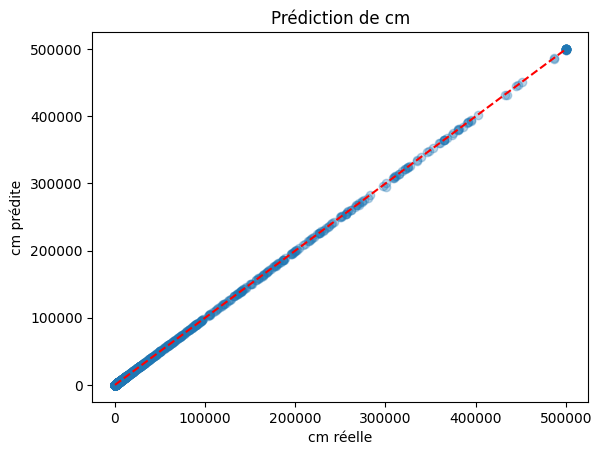

In [8]:
plt.scatter(y_train['CM'], cm_pred, alpha=0.3)
plt.xlabel("cm réelle")
plt.ylabel("cm prédite")
plt.title("Prédiction de cm")
plt.plot([0, max(y_train['CM'])], [0, max(y_train['CM'])], color='red', linestyle='--')
plt.show()


# 📦 Prédiction Finale de la CHARGE TOTALE (FREQ * CM * Durée)
#Après avoir modélisé FREQ (fréquence des sinistres) et CM (coût moyen), on combine ces deux prédictions avec la variable ANNEE_ASSURANCE (durée d'exposition) pour estimer la CHARGE TOTALE

In [12]:
annee_assurance = np.array(df_train_x['ANNEE_ASSURANCE'])


In [14]:
# Calcul de la charge prédite
charge_pred = y_pred * cm_pred * df_train_x['ANNEE_ASSURANCE']

# Charge réelle
charge_true = y_train["CHARGE"]

#  Évaluation

rmse_charge = np.sqrt(mean_squared_error(charge_true, charge_pred))
r2_charge = r2_score(charge_true, charge_pred)

print(" Évaluation finale sur la CHARGE TOTALE :")
print(f" RMSE charge : {rmse_charge:.5f}")
print(f" R²   charge : {r2_charge:.5f}")


 Évaluation finale sur la CHARGE TOTALE :
 RMSE charge : 21.66912
 R²   charge : 0.99999


**Interprétation :**
**Le RMSE très bas indique une erreur moyenne de prédiction très faible, ce qui signifie que la charge totale estimée est très proche de la réalité.**
***Le R² ≈ 1.0 signifie que le modèle explique quasiment toute la variance de la charge réelle observée .... performance exceptionnelle.***

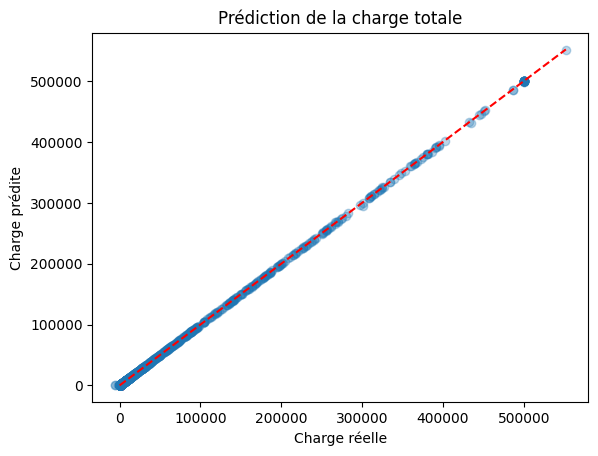

In [15]:
plt.scatter(charge_true, charge_pred, alpha=0.3)
plt.xlabel("Charge réelle")
plt.ylabel("Charge prédite")
plt.title("Prédiction de la charge totale")
plt.plot([0, max(charge_true)], [0, max(charge_true)], color='red', linestyle='--')
plt.show()


#📈 Modélisation de la FREQ avec PoissonRegressor (GLM Poisson)
# 🎯 Objectif :
*** Estimer la fréquence des sinistres (FREQ) à l’aide d’un modèle linéaire généralisé (GLM) basé sur une distribution de Poisson, adaptée aux variables discrètes et positives.***



In [16]:
#  Détection automatique des colonnes catégorielles
categorical_cols = df_train_x.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_train_x.select_dtypes(include=['number']).columns.tolist()

print(f"Colonnes catégorielles : {categorical_cols}")
print(f"Colonnes numériques : {numerical_cols}")
df_train_x[categorical_cols] = df_train_x[categorical_cols].astype(str)


#Construction du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Application
df_train_x_encoded = pd.DataFrame(
    preprocessor.fit_transform(df_train_x),
    columns=preprocessor.get_feature_names_out()
)

#Vérification
print("Shape initiale :", df_train_x.shape)
print("Shape après encodage :", df_train_x_encoded.shape)
df_train_x_encoded.head()


Colonnes catégorielles : ['ACTIVIT2', 'VOCATION', 'ADOSS', 'CARACT1', 'CARACT3', 'INDEM1', 'CARACT4', 'TYPBAT1', 'INDEM2', 'FRCH1', 'FRCH2', 'DEROG1', 'DEROG2', 'DEROG3', 'DEROG4', 'DEROG5', 'DEROG6', 'DEROG7', 'DEROG8', 'DEROG9', 'DEROG10', 'DEROG11', 'DEROG12', 'DEROG13', 'DEROG14', 'DEROG16', 'TAILLE1', 'TAILLE2', 'KAPITAL34', 'KAPITAL35', 'KAPITAL36', 'KAPITAL37', 'KAPITAL38', 'KAPITAL39', 'KAPITAL40', 'KAPITAL41', 'KAPITAL42', 'KAPITAL43', 'SURFACE4', 'SURFACE6', 'COEFASS', 'RISK6', 'RISK8', 'RISK9', 'RISK10', 'RISK11', 'RISK12', 'RISK13', 'EQUIPEMENT2', 'EQUIPEMENT5', 'DISTANCE_111', 'DISTANCE_112', 'DISTANCE_121', 'DISTANCE_122', 'DISTANCE_123', 'DISTANCE_124', 'DISTANCE_131', 'DISTANCE_132', 'DISTANCE_133', 'DISTANCE_141', 'DISTANCE_142', 'DISTANCE_211', 'DISTANCE_212', 'DISTANCE_213', 'DISTANCE_221', 'DISTANCE_222', 'DISTANCE_223', 'DISTANCE_231', 'DISTANCE_242', 'DISTANCE_243', 'DISTANCE_244', 'DISTANCE_311', 'DISTANCE_312', 'DISTANCE_313', 'DISTANCE_321', 'DISTANCE_322', 'DI

,cat__ACTIVIT2_ACT2,cat__ACTIVIT2_ACT3,cat__ACTIVIT2_ACT4,cat__ACTIVIT2_ACT5,cat__ACTIVIT2_ACT6,cat__ACTIVIT2_ACT7,cat__ACTIVIT2_ACT8,cat__ACTIVIT2_ACT9,cat__VOCATION_VOC2,cat__VOCATION_VOC3,...,remainder__RISK5,remainder__RISK7,remainder__EQUIPEMENT1,remainder__EQUIPEMENT3,remainder__EQUIPEMENT4,remainder__EQUIPEMENT6,remainder__EQUIPEMENT7,remainder__ZONE_VENT,remainder__ANNEE_ASSURANCE,remainder__ZONE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,100.0,0.0,0.0,1.0,9.0,10.0,2.0,1.000000,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,100.0,0.0,0.0,1.0,9.0,10.0,2.0,1.000000,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,100.0,0.0,0.0,1.0,8.0,9.0,2.0,0.402740,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,100.0,0.0,0.0,1.0,2.0,3.0,2.0,0.246575,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.0,100.0,0.0,0.0,1.0,7.0,8.0,1.0,0.838356,3.0


In [17]:
#  Cible
y_freq = y_train['FREQ'].values

# Entraînement du modèle GLM Poisson (scikit-learn)
poisson_model = PoissonRegressor(alpha=0.0, max_iter=1000)
poisson_model.fit(df_train_x_encoded, y_freq)

#Prédictions
y_pred_glm = poisson_model.predict(df_train_x_encoded)

#Affichage du RMSE
rmse_glm = np.sqrt(mean_squared_error(y_freq, y_pred_glm))
print(f"RMSE PoissonRegressor : {rmse_glm:.4f}")

#Affichage des coefficients
coef_df = pd.Series(poisson_model.coef_, index=df_train_x_encoded.columns)
print(coef_df.sort_values(ascending=False))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


RMSE PoissonRegressor : 0.3571
remainder__ZONE       0.0
cat__ACTIVIT2_ACT2    0.0
cat__ACTIVIT2_ACT3    0.0
cat__ACTIVIT2_ACT4    0.0
cat__ACTIVIT2_ACT5    0.0
                     ... 
cat__VOCATION_VOC4    0.0
cat__VOCATION_VOC3    0.0
cat__VOCATION_VOC2    0.0
cat__ACTIVIT2_ACT9    0.0
cat__ACTIVIT2_ACT8    0.0
Length: 1030, dtype: float64


In [18]:
rmse_xgb = np.sqrt(mean_squared_error(y_train['FREQ'], y_pred))
rmse_glm = np.sqrt(mean_squared_error(y_train['FREQ'], y_pred_glm))

print(f"RMSE XGBoost : {rmse_xgb:.4f}")
print(f"RMSE GLM Poisson : {rmse_glm:.4f}")


RMSE XGBoost : 0.0001
RMSE GLM Poisson : 0.3571


  ACTIVITE  RMSE_XGB  RMSE_GLM      GAIN
3     ACT4  0.000117  0.475523  0.475407
0     ACT1  0.000160  0.393458  0.393298
7     ACT8  0.000024  0.249229  0.249204
8     ACT9  0.000036  0.239122  0.239086
4     ACT5  0.000070  0.200430  0.200360
1     ACT2  0.000014  0.094588  0.094575
2     ACT3  0.000019  0.079159  0.079140
6     ACT7  0.000003  0.077537  0.077534
5     ACT6  0.000009  0.045735  0.045726


/tmp/ipython-input-19-2293778956.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_eval.groupby('ACTIVITE').apply(


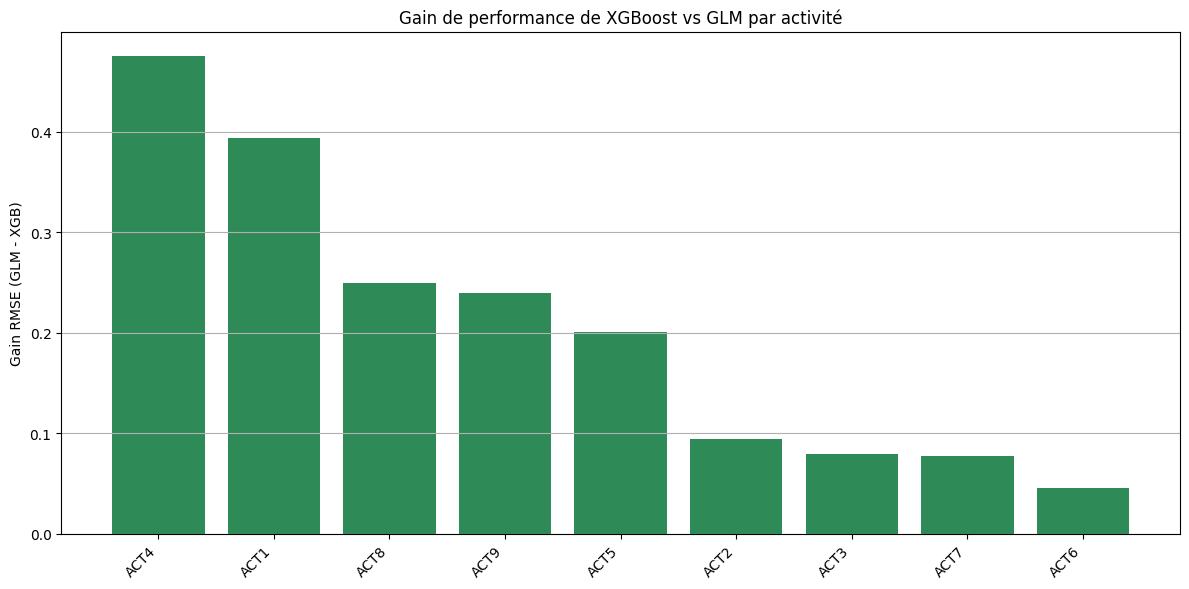

In [19]:
# On crée une copie du DataFrame de base pour ajouter les prédictions
df_eval = df_train_x.copy()
df_eval['ACTIVITE'] = df_eval['ACTIVIT2'].astype(str)
df_eval['FREQ_true'] = y_train['FREQ']
df_eval['FREQ_pred_xgb'] = y_pred
df_eval['FREQ_pred_glm'] = y_pred_glm

# Calcul du RMSE par activité
grouped = df_eval.groupby('ACTIVITE').apply(
    lambda g: pd.Series({
        'RMSE_XGB': np.sqrt(mean_squared_error(g['FREQ_true'], g['FREQ_pred_xgb'])),
        'RMSE_GLM': np.sqrt(mean_squared_error(g['FREQ_true'], g['FREQ_pred_glm']))
    })
).reset_index()

# Calcul du gain
grouped['GAIN'] = grouped['RMSE_GLM'] - grouped['RMSE_XGB']

# Tri décroissant selon le gain
grouped_sorted = grouped.sort_values(by='GAIN', ascending=False)

# Affichage du tableau
print(grouped_sorted)

# Visualisation
plt.figure(figsize=(12, 6))
plt.bar(grouped_sorted['ACTIVITE'], grouped_sorted['GAIN'], color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Gain RMSE (GLM - XGB)")
plt.title("Gain de performance de XGBoost vs GLM par activité")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#  Modélisation du Coût Moyen (CM) avec TweedieRegressor (GLM Tweedie)
# 🎯 Objectif :
*** Prédire le coût moyen par sinistre (CM) via un modèle GLM Tweedie, une généralisation des distributions exponentielles, parfaite pour des valeurs continues, asymétriques et positives, souvent avec des zéros.***



In [20]:
#  Cible
y_cm = y_train['CM'].values

#  Entraînement du modèle GLM Poisson (scikit-learn)
tweedie_model = TweedieRegressor(
    power=1.5,
    alpha=0.1,
    link='log'
)  # alpha=0.0 = pas de régularisation
tweedie_model.fit(df_train_x_encoded, y_cm)

#  Prédictions
y_pred_glm_cm = tweedie_model.predict(df_train_x_encoded)

# Affichage du RMSE
rmse_glm_cm = np.sqrt(mean_squared_error(y_cm, y_pred_glm_cm))
print(f"RMSE tweedieRegressor : {rmse_glm_cm:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


RMSE tweedieRegressor : 6699.9444


In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_xgb_cm = np.sqrt(mean_squared_error(y_train['CM'], cm_pred))
rmse_glm_cm = np.sqrt(mean_squared_error(y_train['CM'], y_pred_glm_cm))

print(f"RMSE XGBoost : {rmse_xgb_cm:.4f}")
print(f"RMSE GLM Poisson : {rmse_glm_cm:.4f}")

RMSE XGBoost : 16.7436
RMSE GLM Poisson : 6699.9444


  ACTIVITE   RMSE_XGB      RMSE_GLM          GAIN
3     ACT4  24.377387  11918.882473  11894.505086
2     ACT3   4.187884   7428.445958   7424.258075
0     ACT1  18.788603   7057.775855   7038.987252
4     ACT5   6.382374   5553.018611   5546.636236
1     ACT2   4.635663   4817.792075   4813.156411
7     ACT8   3.276833   4448.511465   4445.234632
8     ACT9   1.464452   1087.011644   1085.547191
6     ACT7   0.008428    203.672017    203.663589
5     ACT6   0.000000    182.557778    182.557778


/tmp/ipython-input-22-2798739605.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_eval.groupby('ACTIVITE').apply(


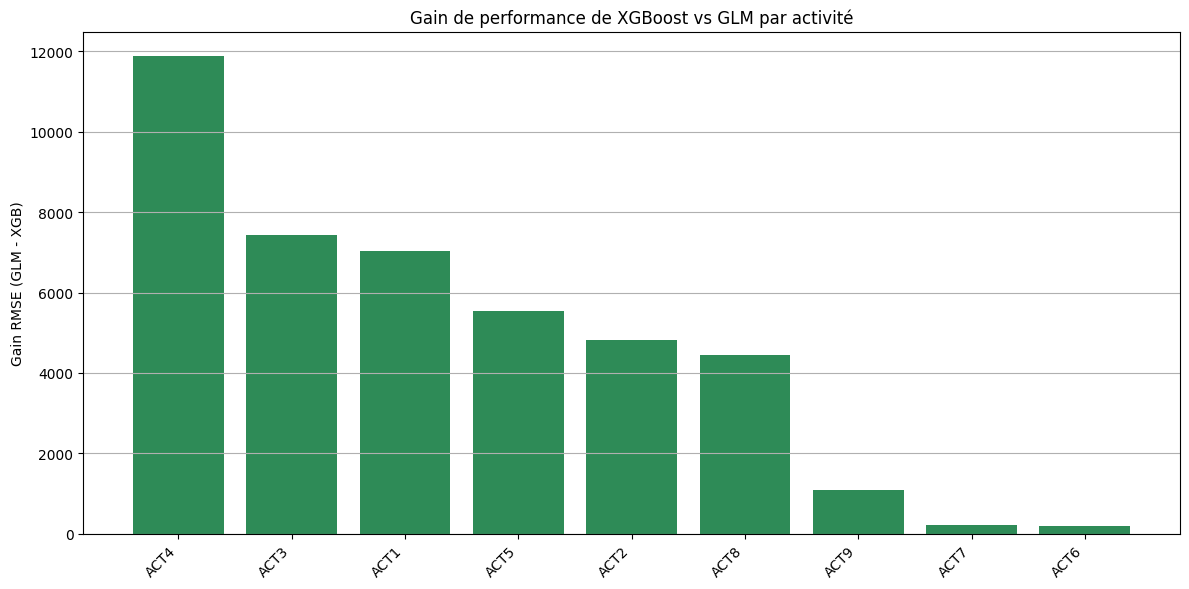

In [22]:
# On crée une copie du DataFrame de base pour ajouter les prédictions
df_eval = df_train_x.copy()
df_eval['ACTIVITE'] = df_eval['ACTIVIT2'].astype(str)  # Juste au cas où
df_eval['CM_true'] = y_train['CM']
df_eval['CM_pred_xgb'] = cm_pred
df_eval['CM_pred_glm'] = y_pred_glm_cm

# Calcul du RMSE par activité
grouped = df_eval.groupby('ACTIVITE').apply(
    lambda g: pd.Series({
        'RMSE_XGB': np.sqrt(mean_squared_error(g['CM_true'], g['CM_pred_xgb'])),
        'RMSE_GLM': np.sqrt(mean_squared_error(g['CM_true'], g['CM_pred_glm']))
    })
).reset_index()

# Calcul du gain
grouped['GAIN'] = grouped['RMSE_GLM'] - grouped['RMSE_XGB']

# Tri décroissant selon le gain
grouped_sorted = grouped.sort_values(by='GAIN', ascending=False)

# Affichage du tableau
print(grouped_sorted)

# Visualisation
plt.figure(figsize=(12, 6))
plt.bar(grouped_sorted['ACTIVITE'], grouped_sorted['GAIN'], color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Gain RMSE (GLM - XGB)")
plt.title("Gain de performance de XGBoost vs GLM par activité")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 🧾 Calcul et Évaluation de la CHARGE TOTALE (FREQ  CM  Durée)
# 🎯 Objectif final :
*** Combiner les deux composantes FREQ prédite et CM prédite, pondérées par la durée d’assurance pour reconstituer la CHARGE TOTALE par client. ***

In [23]:
charge_pred_glm = y_pred_glm * y_pred_glm_cm *df_train_x['ANNEE_ASSURANCE']

In [24]:
rmse_charge_xgb = np.sqrt(mean_squared_error(y_train['CHARGE'], charge_pred))
rmse_charge_glm = np.sqrt(mean_squared_error(y_train['CHARGE'], charge_pred_glm))

print(f"RMSE XGBoost CHARGE: {rmse_charge_xgb:.4f}")
print(f"RMSE GLM CHARGE    : {rmse_charge_glm:.4f}")


RMSE XGBoost CHARGE: 21.6691
RMSE GLM CHARGE    : 6802.9809


# 📦 Application des Méthodes sur le Fichier TEST

# Importation du fichier test

In [ ]:
df_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/test.csv',
    na_values=["", " ", "NA", "??", "-", "--", "nan"]
)

<ipython-input-6-2126905494>:1: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(


# Application des mêmes méthodes de remplissage que sur les données d'entraînement

In [ ]:
fill_missing_xgb_numeric(df_test, 'CARACT2')



⚙️ Traitement de la colonne : CARACT2


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00        98

    accuracy                           1.00      1078
   macro avg       1.00      1.00      1.00      1078
weighted avg       1.00      1.00      1.00      1078

✅ Accuracy : 1.0


In [ ]:
risk_cols = ['RISK1', 'RISK2', 'RISK3', 'RISK4', 'RISK5', 'RISK7']


for col in risk_cols:
    fill_missing_xgb_numeric(df_test, col)



⚙️ Traitement de la colonne : RISK1


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       831
           2       0.94      0.88      0.91     15258
           3       0.93      0.97      0.95     30223
           4       0.98      0.86      0.92      2701
           5       1.00      1.00      1.00       205
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00     39894

    accuracy                           0.97     89250
   macro avg       0.98      0.97      0.98     89250
weighted avg       0.97      0.97      0.97     89250

✅ Accuracy : 0.9654901960784313

⚙️ Traitement de la colonne : RISK2


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        38
           7       1.00      1.00      1.00        66
           8       1.00      1.00      1.00        85
           9       1.00      1.00      1.00       122
          10       1.00      1.00      1.00       185
          11       1.00      1.00      1.00       279
          12       1.00      1.00      1.00       422
          13       1.00      1.00      1.00       607
          14       1.00      1.00      1.00       893
          15       0.99      1.00      0.99      1204
          16       0.98      0.98      0.98      1495
          17       0.97    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        69
           5       1.00      1.00      1.00       234
           6       1.00      1.00      1.00       484
           7       1.00      1.00      1.00      1509
           8       0.96      0.97      0.96      2752
           9       0.94      0.91      0.92      3973
          10       0.89      0.89      0.89      7417
          11       0.83      0.84      0.84      8328
          12       0.82      0.81      0.81      7388
          13       0.84      0.84      0.84      6354
          14       0.88      0.90      0.89      4580
          15       0.95      0.94      0.94      2743
          16       0.98      0.98      0.98      1626
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       0.94      0.78      0.85      7751
           2       0.84      0.94      0.89     23533
           3       0.86      0.78      0.82     12058
           4       0.95      0.84      0.89      4463
           5       1.00      0.97      0.98      1149
           6       1.00      1.00      1.00       254
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00     39894

    accuracy                           0.93     89250
   macro avg       0.97      0.94      0.95     89250
weighted avg       0.93      0.93      0.93     89250

✅ Accuracy : 0.9278319327731093

⚙️ Traitement de la colonne : RISK5


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       526
           1       1.00      1.00      1.00       704
           2       1.00      1.00      1.00       968
           3       1.00      1.00      1.00       671
           4       0.90      0.96      0.92     24949
           5       0.89      0.84      0.87     17734
           6       0.95      0.75      0.84      3713
           7       1.00      1.00      1.00        75
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        11
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00     39894

    accuracy                           0.95     89250
   macro avg       0.89      0.88      0.89     89250
weighted avg       0.95      0.95      0.95     89250

✅ Accuracy : 0.9463529411764706

⚙️ Traitement de la colonne : RISK7


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10788
           1       0.99      0.99      0.99      4003
           2       0.98      0.98      0.98      4527
           3       0.99      0.99      0.99     19459
           4       0.99      0.99      0.99      2731
           5       1.00      1.00      1.00     47741
           6       1.00      1.00      1.00         1

    accuracy                           1.00     89250
   macro avg       0.99      0.99      0.99     89250
weighted avg       1.00      1.00      1.00     89250

✅ Accuracy : 0.9968515406162465


In [ ]:
kapital_cols = [
    'KAPITAL11', 'KAPITAL15', 'KAPITAL16', 'KAPITAL17', 'KAPITAL18', 'KAPITAL19',
    'KAPITAL20', 'KAPITAL21', 'KAPITAL22', 'KAPITAL23', 'KAPITAL24',
    'KAPITAL29', 'KAPITAL30', 'KAPITAL31', 'KAPITAL33'
]

for col in kapital_cols:
    fill_missing_xgb_numeric(df_test, col)


⚙️ Traitement de la colonne : KAPITAL11


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27767
           1       1.00      1.00      1.00      2560
           2       1.00      1.00      1.00      2093
           3       1.00      1.00      1.00      3485
           4       1.00      1.00      1.00      4917
           5       1.00      1.00      1.00      3111
           6       1.00      1.00      1.00      5640
           7       1.00      1.00      1.00      4129
           8       1.00      1.00      1.00      3152
           9       1.00      1.00      1.00      2133
          10       1.00      1.00      1.00      2745
          11       1.00      1.00      1.00      1427
          12       1.00      1.00      1.00      2757

    accuracy                           1.00     65916
   macro avg       1.00      1.00      1.00     65916
weighted avg       1.00      1.00      1.00     65916

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL15


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5880
           1       1.00      1.00      1.00       113
           2       1.00      1.00      1.00       226
           3       1.00      1.00      1.00       141
           4       1.00      1.00      1.00        32
           5       1.00      1.00      1.00        76

    accuracy                           1.00      6468
   macro avg       1.00      1.00      1.00      6468
weighted avg       1.00      1.00      1.00      6468

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL16


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13520
           1       1.00      1.00      1.00       190
           2       1.00      1.00      1.00       342
           3       1.00      1.00      1.00       324
           4       1.00      1.00      1.00       139
           5       1.00      1.00      1.00       357

    accuracy                           1.00     14872
   macro avg       1.00      1.00      1.00     14872
weighted avg       1.00      1.00      1.00     14872

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL17


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8540
           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00       278
           3       1.00      1.00      1.00       243
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00       145

    accuracy                           1.00      9394
   macro avg       1.00      1.00      1.00      9394
weighted avg       1.00      1.00      1.00      9394

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL18


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4160
           1       1.00      1.00      1.00       183
           2       1.00      1.00      1.00       192
           3       1.00      1.00      1.00        31
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         6

    accuracy                           1.00      4576
   macro avg       1.00      1.00      1.00      4576
weighted avg       1.00      1.00      1.00      4576

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL19


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13890
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       178
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00       498
           6       1.00      1.00      1.00        54
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        34
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00       300

    accuracy                           1.00     15279
   macro avg       1.00      1.00      1.00     15279
weighted avg       1.00      1.00      1.00     15279

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL20


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3640
           1       1.00      1.00      1.00        72
           2       1.00      1.00      1.00       138
           3       1.00      1.00      1.00        68
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        60

    accuracy                           1.00      4004
   macro avg       1.00      1.00      1.00      4004
weighted avg       1.00      1.00      1.00      4004

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL21


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54792
           1       0.97      0.81      0.88       907
           2       0.82      0.76      0.79      4249
           3       0.76      0.78      0.77      7432
           4       0.95      0.57      0.71      3534
           5       0.69      0.92      0.79     12364
           6       0.96      0.68      0.80      2638
           7       0.98      0.69      0.81      1566
           8       0.89      0.72      0.80      4035
           9       1.00      1.00      1.00       103
          10       0.96      0.77      0.86      2917

    accuracy                           0.91     94537
   macro avg       0.91      0.79      0.84     94537
weighted avg       0.92      0.91      0.91     94537

✅ Accuracy : 0.9106593185736801

⚙️ Traitement de la colonne : KAPITAL22


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6160
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        81
           3       1.00      1.00      1.00        74
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00       130
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        45
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00       158

    accuracy                           1.00      6776
   macro avg       1.00      1.00      1.00      6776
weighted avg       1.00      1.00      1.00      6776

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL23


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80060
           1       0.93      0.97      0.95      4182
           2       0.94      0.94      0.94      4626
           3       0.97      0.92      0.94      2647
           4       1.00      0.94      0.97      1007
           5       0.97      0.97      0.97      1693
           6       1.00      1.00      1.00       476
           7       1.00      1.00      1.00       203
           8       1.00      1.00      1.00       270
           9       1.00      1.00      1.00        78
          10       1.00      1.00      1.00       333

    accuracy                           0.99     95575
   macro avg       0.98      0.98      0.98     95575
weighted avg       0.99      0.99      0.99     95575

✅ Accuracy : 0.9927386868951086

⚙️ Traitement de la colonne : KAPITAL24


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86971
           1       0.98      1.00      0.99      4723
           2       1.00      0.97      0.98      2569
           3       1.00      0.99      1.00       908
           4       1.00      1.00      1.00       301
           5       1.00      1.00      1.00       197

    accuracy                           1.00     95669
   macro avg       1.00      0.99      0.99     95669
weighted avg       1.00      1.00      1.00     95669

✅ Accuracy : 0.9988606549666036

⚙️ Traitement de la colonne : KAPITAL29


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6030
           1       1.00      1.00      1.00       372
           2       1.00      1.00      1.00       231

    accuracy                           1.00      6633
   macro avg       1.00      1.00      1.00      6633
weighted avg       1.00      1.00      1.00      6633

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL30


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4250
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       194

    accuracy                           1.00      4675
   macro avg       1.00      1.00      1.00      4675
weighted avg       1.00      1.00      1.00      4675

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL31
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17730
           1       1.00      1.00      1.00      1421
           2       1.00      1.00      1.00       352

    accuracy                           1.00     19503
   macro avg       1.00      1.00      1.00     19503
weighted avg       1.00      1.00      1.00     19503

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : KAPITAL33
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44290
           1 

In [ ]:
surface_cols = [
     'SURFACE3','SURFACE7', 'SURFACE8', 'SURFACE9',
    'SURFACE10', 'SURFACE11', 'SURFACE18', 'SURFACE19'
]

for col in surface_cols:
    fill_missing_xgb_numeric(df_test, col)



⚙️ Traitement de la colonne : SURFACE3


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4787
           1       1.00      1.00      1.00       932
           2       1.00      1.00      1.00      1474
           3       1.00      1.00      1.00      1798
           4       1.00      1.00      1.00      1052
           5       1.00      1.00      1.00       903
           6       1.00      1.00      1.00      1160
           7       1.00      1.00      1.00       983
           8       1.00      1.00      1.00      1079
           9       1.00      1.00      1.00       977
          10       1.00      1.00      1.00      1127
          11       1.00      1.00      1.00       952
          12       1.00      1.00      1.00      1057
          13       1.00      1.00      1.00      1007
          14       1.00      1.00      1.00      1071
          15       1.00      1.00      1.00       903
          16       1.00      1.00      1.00       985
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.84      1.00      0.91     53788
           1       0.96      0.52      0.68     23504
           2       0.88      0.90      0.89      8690
           3       0.95      0.98      0.96      4592
           4       1.00      1.00      1.00      1288
           5       1.00      1.00      1.00       856
           6       1.00      1.00      1.00       775
           7       1.00      1.00      1.00       372
           8       1.00      1.00      1.00       304
           9       1.00      1.00      1.00       200
          10       1.00      1.00      1.00       155
          11       1.00      1.00      1.00       104
          12       1.00      1.00      1.00        64
          13       1.00      1.00      1.00        41
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00         5
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56640
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00       125
           3       1.00      1.00      1.00        91
           4       1.00      1.00      1.00        67
           5       1.00      1.00      1.00        52
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        73
           8       1.00      1.00      1.00        59
           9       1.00      1.00      1.00        56
          10       1.00      1.00      1.00        77
          11       1.00      1.00      1.00        65
          12       1.00      1.00      1.00        90
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00        88
          16       1.00      1.00      1.00       110
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     32600
           1       1.00      0.54      0.70      3245
           2       1.00      1.00      1.00         6
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         5
           5       0.00      0.00      0.00         1

    accuracy                           0.96     35860
   macro avg       0.83      0.70      0.75     35860
weighted avg       0.96      0.96      0.95     35860

✅ Accuracy : 0.9584774121583938

⚙️ Traitement de la colonne : SURFACE10


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      7873
           1       0.86      1.00      0.93     50333
           2       0.94      0.70      0.80     17126
           3       0.93      0.91      0.92      9363
           4       0.98      0.93      0.96      2786
           5       1.00      0.99      1.00      1783
           6       1.00      1.00      1.00      1455
           7       1.00      1.00      1.00       854
           8       1.00      1.00      1.00       707
           9       1.00      1.00      1.00       391
          10       1.00      1.00      1.00       366
          11       1.00      1.00      1.00       241
          12       1.00      1.00      1.00       186
          13       1.00      1.00      1.00       114
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00        60
          16       1.00      1.00      1.00        35
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6363
           1       1.00      1.00      1.00      1214
           2       1.00      1.00      1.00      1741
           3       1.00      1.00      1.00      2178
           4       1.00      1.00      1.00      1242
           5       1.00      1.00      1.00      1061
           6       1.00      1.00      1.00      1358
           7       1.00      1.00      1.00      1139
           8       1.00      1.00      1.00      1226
           9       1.00      1.00      1.00      1094
          10       1.00      1.00      1.00      1304
          11       1.00      1.00      1.00      1064
          12       1.00      1.00      1.00      1128
          13       1.00      1.00      1.00      1064
          14       1.00      1.00      1.00      1186
          15       1.00      1.00      1.00       936
          16       1.00      1.00      1.00      1056
          17       1.00    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     56319
           1       0.53      0.29      0.38      5409
           2       0.57      0.53      0.55      3152
           3       0.73      0.65      0.69      1975
           4       0.78      0.90      0.84      1388
           5       0.98      0.92      0.95      1000
           6       0.98      0.86      0.92       762
           7       0.98      0.95      0.96       571
           8       1.00      0.94      0.97       461
           9       0.90      0.92      0.91       328
          10       0.94      0.91      0.92       306
          11       0.96      0.89      0.92       237
          12       0.94      0.88      0.91       219
          13       0.97      0.86      0.91       165
          14       0.96      0.78      0.86       144
          15       0.83      0.78      0.81       116
          16       0.92      0.79      0.85       113
          17       0.86    

<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21630
           1       1.00      1.00      1.00       134
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00       135
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        89
           6       1.00      1.00      1.00        82
           7       1.00      1.00      1.00        78
           8       1.00      1.00      1.00        66
           9       1.00      1.00      1.00        61
          10       1.00      1.00      1.00        37
          11       1.00      1.00      1.00      1290

    accuracy                           1.00     23793
   macro avg       1.00      1.00      1.00     23793
weighted avg       1.00      1.00      1.00     23793

✅ Accuracy : 1.0


In [ ]:
fill_missing_xgb_numeric(df_test, 'ZONE_VENT')



⚙️ Traitement de la colonne : ZONE_VENT


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       0.99      0.93      0.96     21760
           1       0.96      1.00      0.98     54663
           2       1.00      0.93      0.96     14759

    accuracy                           0.97     91182
   macro avg       0.98      0.95      0.97     91182
weighted avg       0.97      0.97      0.97     91182

✅ Accuracy : 0.9713868965365972


In [ ]:
fill_missing_xgb_numeric(df_test, 'DUREE_REQANEUF')



⚙️ Traitement de la colonne : DUREE_REQANEUF


<ipython-input-5-3734466024>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna['target_mapped'] = df_notna[target_col].map(value_mapping)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2281
           1       1.00      1.00      1.00     65160
           2       1.00      1.00      1.00      2223
           3       1.00      1.00      1.00      2012

    accuracy                           1.00     71676
   macro avg       1.00      1.00      1.00     71676
weighted avg       1.00      1.00      1.00     71676

✅ Accuracy : 1.0


In [ ]:
RR_cols = ['RR_VOR_MM_A', 'RR_VOR_MMAX_A', 'RRAB_VOR_MM_A', 'RRAB_VOR_MMAX_A']
for col in RR_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : RR_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15651
           1       0.99      1.00      0.99     16028
           2       1.00      1.00      1.00      7125
           3       1.00      1.00      1.00      2471

    accuracy                           0.99     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       0.99      0.99      0.99     41275

✅ Accuracy : 0.9944518473652332

⚙️ Traitement de la colonne : RR_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16734
           1       1.00      1.00      1.00     15542
           2       1.00      1.00      1.00      7005
           3       1.00      1.00      1.00      1994

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weigh

In [ ]:
NBJRR_cols = [
    'NBJRR50_MM_A', 'NBJRR50_MMAX_A', 'NBJRR50_MSOM_A',
    'NBJRR1_MM_A', 'NBJRR1_MMAX_A', 'NBJRR1_MSOM_A',
    'NBJRR5_MM_A', 'NBJRR5_MMAX_A', 'NBJRR5_MSOM_A',
    'NBJRR10_MM_A', 'NBJRR10_MMAX_A', 'NBJRR10_MSOM_A',
    'NBJRR30_MM_A', 'NBJRR30_MMAX_A', 'NBJRR30_MSOM_A',
    'NBJRR100_MM_A', 'NBJRR100_MMAX_A', 'NBJRR100_MSOM_A'
]
for col in NBJRR_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : NBJRR50_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26170
           1       1.00      1.00      1.00      8097
           2       1.00      1.00      1.00      5144
           3       1.00      1.00      1.00      1864

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJRR50_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17823
           1       1.00      0.95      0.98     11949
           2       1.00      1.00      1.00      9018
           3       1.00      1.00      1.00      2485

    accuracy                           0.99     41275
   macro avg       0.99      0.99      0.99     41275
weighted avg      

In [ ]:
NBJFX_cols = [
    'NBJFXI3S10_MM_A', 'NBJFXI3S10_MMAX_A', 'NBJFXI3S10_MSOM_A',
    'NBJFXI3S16_MM_A', 'NBJFXI3S16_MMAX_A', 'NBJFXI3S16_MSOM_A',
    'NBJFXI3S28_MM_A', 'NBJFXI3S28_MMAX_A', 'NBJFXI3S28_MSOM_A',
    'NBJFXY8_MM_A', 'NBJFXY8_MMAX_A', 'NBJFXY8_MSOM_A',
    'NBJFXY10_MM_A', 'NBJFXY10_MMAX_A', 'NBJFXY10_MSOM_A',
    'NBJFXY15_MM_A', 'NBJFXY15_MMAX_A', 'NBJFXY15_MSOM_A'
]
for col in NBJFX_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : NBJFXI3S10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12976
           1       1.00      1.00      1.00     13740
           2       1.00      1.00      1.00      9129
           3       1.00      1.00      1.00      5430

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJFXI3S10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13154
           1       1.00      1.00      1.00     14066
           2       1.00      1.00      1.00      9697
           3       1.00      1.00      1.00      4358

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg

In [ ]:
NBJFF_cols = [
    'NBJFF10_MM_A', 'NBJFF10_MMAX_A', 'NBJFF10_MSOM_A',
    'NBJFF16_MM_A', 'NBJFF16_MMAX_A', 'NBJFF16_MSOM_A',
    'NBJFF28_MM_A', 'NBJFF28_MMAX_A', 'NBJFF28_MSOM_A'
]
for col in NBJFF_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : NBJFF10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7085
           1       1.00      1.00      1.00     12380
           2       1.00      1.00      1.00     15050
           3       1.00      1.00      1.00      6760

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJFF10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6835
           1       1.00      1.00      1.00     11823
           2       1.00      1.00      1.00     15435
           3       1.00      1.00      1.00      7182

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg      

In [ ]:
FMX_cols = [
    'FFM_VOR_MM_A', 'FFM_VOR_MMAX_A',
    'FXI3SAB_VOR_MM_A', 'FXI3SAB_VOR_MMAX_A',
    'FXIAB_VOR_MM_A', 'FXIAB_VOR_MMAX_A',
    'FXYAB_VOR_MM_A', 'FXYAB_VOR_MMAX_A',
    'FFM_VOR_COM_MM_A_Y', 'FFM_VOR_COM_MMAX_A_Y',
    'FXI3SAB_VOR_COM_MM_A_Y', 'FXI3SAB_VOR_COM_MMAX_A_Y'
]
for col in FMX_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)



⚙️ Traitement de la colonne : FFM_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1076
           1       1.00      1.00      1.00     14047
           2       1.00      1.00      1.00     17619
           3       1.00      1.00      1.00      8533

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : FFM_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1057
           1       1.00      1.00      1.00     14297
           2       1.00      1.00      1.00     17407
           3       1.00      1.00      1.00      8514

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg      

In [ ]:
TAMP_cols = [
    'TAMPLIAB_VOR_MM_A', 'TAMPLIAB_VOR_MMAX_A',
    'TAMPLIM_VOR_MM_A', 'TAMPLIM_VOR_MMAX_A',
    'TM_VOR_MM_A', 'TM_VOR_MMAX_A',
    'TMM_VOR_MM_A', 'TMM_VOR_MMAX_A',
    'TMMAX_VOR_MM_A', 'TMMAX_VOR_MMAX_A',
    'TMMIN_VOR_MM_A', 'TMMIN_VOR_MMAX_A',
    'TN_VOR_MM_A', 'TN_VOR_MMAX_A',
    'TNAB_VOR_MM_A', 'TNAB_VOR_MMAX_A',
    'TNMAX_VOR_MM_A', 'TNMAX_VOR_MMAX_A',
    'TX_VOR_MM_A', 'TX_VOR_MMAX_A',
    'TXAB_VOR_MM_A', 'TXAB_VOR_MMAX_A',
    'TXMIN_VOR_MM_A', 'TXMIN_VOR_MMAX_A'
]
for col in TAMP_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : TAMPLIAB_VOR_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      0.99      1.00     12045
           2       0.99      1.00      1.00     19200
           3       1.00      0.99      1.00      9743

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 0.9958812840702604

⚙️ Traitement de la colonne : TAMPLIAB_VOR_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      0.98      0.99     10464
           2       0.98      1.00      0.99     19377
           3       1.00      0.98      0.99     11149

    accuracy                           0.99     41275
   macro avg       0.99      0.99      0.99    

In [ ]:
NBJTMS_cols = ['NBJTMS24_MM_A', 'NBJTMS24_MMAX_A', 'NBJTMS24_MSOM_A']
for col in NBJTMS_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)



⚙️ Traitement de la colonne : NBJTMS24_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16820
           1       1.00      1.00      1.00     17698
           2       1.00      1.00      1.00      5054
           3       1.00      1.00      1.00      1703

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTMS24_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14397
           1       1.00      1.00      1.00     19687
           2       1.00      1.00      1.00      5380
           3       1.00      1.00      1.00      1811

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg    

In [ ]:
NBJTN_cols = [
    'NBJTN10_MM_A', 'NBJTN10_MMAX_A', 'NBJTN10_MSOM_A',
    'NBJTNI10_MM_A', 'NBJTNI10_MMAX_A', 'NBJTNI10_MSOM_A',
    'NBJTN5_MM_A', 'NBJTN5_MMAX_A', 'NBJTN5_MSOM_A',
    'NBJTNS25_MM_A', 'NBJTNS25_MMAX_A', 'NBJTNS25_MSOM_A',
    'NBJTNI15_MM_A', 'NBJTNI15_MMAX_A', 'NBJTNI15_MSOM_A',
    'NBJTNI20_MM_A', 'NBJTNI20_MMAX_A', 'NBJTNI20_MSOM_A',
    'NBJTNS20_MM_A', 'NBJTNS20_MMAX_A', 'NBJTNS20_MSOM_A'
]
for col in NBJTN_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)



⚙️ Traitement de la colonne : NBJTN10_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27116
           1       1.00      1.00      1.00     10804
           2       1.00      1.00      1.00      2900
           3       1.00      1.00      1.00       455

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTN10_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23912
           1       1.00      1.00      1.00     11959
           2       1.00      1.00      1.00      4670
           3       1.00      1.00      1.00       734

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg      

In [ ]:
NBJTX_cols = ['NBJTX25_MM_A', 'NBJTX25_MMAX_A', 'NBJTX25_MSOM_A',
    'NBJTX0_MM_A', 'NBJTX0_MMAX_A', 'NBJTX0_MSOM_A',
    'NBJTXI27_MM_A', 'NBJTXI27_MMAX_A', 'NBJTXI27_MSOM_A',
    'NBJTXS32_MM_A', 'NBJTXS32_MMAX_A', 'NBJTXS32_MSOM_A',
    'NBJTXI20_MM_A', 'NBJTXI20_MMAX_A', 'NBJTXI20_MSOM_A',
    'NBJTX30_MM_A', 'NBJTX30_MMAX_A', 'NBJTX30_MSOM_A',
    'NBJTX35_MM_A', 'NBJTX35_MMAX_A', 'NBJTX35_MSOM_A']
for col in NBJTX_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : NBJTX25_MM_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8732
           1       1.00      1.00      1.00     14662
           2       1.00      1.00      1.00     10586
           3       1.00      1.00      1.00      7295

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg       1.00      1.00      1.00     41275

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : NBJTX25_MMAX_A
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4514
           1       1.00      1.00      1.00      8163
           2       1.00      1.00      1.00     19755
           3       1.00      1.00      1.00      8843

    accuracy                           1.00     41275
   macro avg       1.00      1.00      1.00     41275
weighted avg      

In [ ]:
distance_cols =  ['DISTANCE_111', 'DISTANCE_112', 'DISTANCE_121', 'DISTANCE_122', 'DISTANCE_123', 'DISTANCE_124', 'DISTANCE_131', 'DISTANCE_132', 'DISTANCE_133', 'DISTANCE_141', 'DISTANCE_142', 'DISTANCE_212', 'DISTANCE_213', 'DISTANCE_221', 'DISTANCE_222', 'DISTANCE_223', 'DISTANCE_242', 'DISTANCE_243', 'DISTANCE_321', 'DISTANCE_322', 'DISTANCE_323', 'DISTANCE_331', 'DISTANCE_332', 'DISTANCE_333', 'DISTANCE_334', 'DISTANCE_335', 'DISTANCE_411', 'DISTANCE_412', 'DISTANCE_421', 'DISTANCE_422', 'DISTANCE_423', 'DISTANCE_511', 'DISTANCE_512', 'DISTANCE_521', 'DISTANCE_522', 'DISTANCE_523']


for col in distance_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : DISTANCE_111
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     18373
           1       0.99      0.77      0.86     15889
           2       0.98      0.97      0.97      7013

    accuracy                           0.90     41275
   macro avg       0.93      0.91      0.92     41275
weighted avg       0.92      0.90      0.90     41275

✅ Accuracy : 0.9043488794669897

⚙️ Traitement de la colonne : DISTANCE_112
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     24042
           1       0.97      0.40      0.57     13668
           2       0.95      0.83      0.88      3565

    accuracy                           0.79     41275
   macro avg       0.89      0.74      0.77     41275
weighted avg       0.83      0.79      0.76     41275

✅ Accuracy : 0.7879345850999394

⚙️ Traitement de la colon

In [ ]:
R1_cols = ['DISTANCE_1','PROPORTION_11', 'PROPORTION_12', 'PROPORTION_13', 'PROPORTION_14',
'PROPORTION_22', 'PROPORTION_32', 'PROPORTION_33',
'PROPORTION_41', 'PROPORTION_42', 'PROPORTION_51', 'PROPORTION_52','DISTANCE_313','DISTANCE_312','DISTANCE_311']


for col in R1_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : DISTANCE_1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.55      0.71     16393
           1       0.59      1.00      0.74     17168
           2       1.00      0.40      0.57      7714

    accuracy                           0.71     41275
   macro avg       0.86      0.65      0.67     41275
weighted avg       0.83      0.71      0.69     41275

✅ Accuracy : 0.7073531193216233

⚙️ Traitement de la colonne : PROPORTION_11
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     79818
           1       1.00      0.71      0.83      7925
           2       1.00      0.96      0.98      2261
           3       1.00      1.00      1.00       672
           4       1.00      1.00      1.00       282
           5       1.00      1.00      1.00       139
           6       1.00      1.00      1.00        64
       

In [ ]:
R2_cols =  ['LOG_INC', 'IND_Y2_Y3', 'IND_Y4_Y5', 'MEN', 'IND', 'MEN_5IND',
                      'PROPORTION_21', 'IND_Y7_Y8', 'BDTOPO_BAT_MAX_HAUTEUR_MAX', 'BDTOPO_BAT_MAX_HAUTEUR', 'HAUTEUR_MAX', 'HAUTEUR',
                      'NB_CASERNES', 'LOG_SOC', 'ALTITUDE_1', 'NBJTXI20_MMAX_A', 'IND_Y9', 'NBJTXI27_MMAX_A', 'TAMPLIAB_VOR_MMAX_A', 'FXYAB_VOR_MMAX_A',
                      'TAMPLIAB_VOR_MM_A', 'FXYAB_VOR_MM_A', 'IND_Y3_Y4', 'MEN_FMP', 'LOG_A1_A2', 'ALTITUDE_5', 'MEN_COLL']


for col in R2_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : LOG_INC
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         3

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : IND_Y2_Y3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2030
           1       1.00      1.00      1.00       203

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : IND_Y4_Y5
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   

In [ ]:
R3_cols =  ['CARACT1', 'CARACT3', 'TYPBAT1', 'INDEM2', 'FRCH2', 'DEROG12', 'DEROG13','DEROG16', 'RISK6', 'RISK8',
                         'RISK9', 'RISK10', 'RISK12', 'RISK13', 'EQUIPEMENT2', 'EQUIPEMENT5','PROPORTION_23', 'PROPORTION_24', 'PROPORTION_31',
                        'MEN_PAUV', 'MEN_1IND', 'MEN_PROP', 'MEN_MAIS', 'LOG_AVA1', 'LOG_A2_A3', 'LOG_APA3', 'IND_0_Y1', 'IND_Y5_Y6', 'IND_Y6_Y7', 'IND_Y8_Y9', 'IND_SNV',
                        'MEN_SURF', 'ALTITUDE_2', 'ALTITUDE_3', 'ALTITUDE_4', 'FFM_VOR_COM_MM_A_Y', 'ESPINSEE']


for col in R3_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : CARACT1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     68695
           1       1.00      0.95      0.97      2804
           2       1.00      0.98      0.99     23205

    accuracy                           0.99     94704
   macro avg       1.00      0.98      0.99     94704
weighted avg       0.99      0.99      0.99     94704

✅ Accuracy : 0.9929675620881906

⚙️ Traitement de la colonne : CARACT3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1898
           1       1.00      1.00      1.00      1705
           2       1.00      1.00      1.00       251

    accuracy                           1.00      3854
   macro avg       1.00      1.00      1.00      3854
weighted avg       1.00      1.00      1.00      3854

✅ Accuracy : 0.9997405293201869

⚙️ Traitement de la colonne : TYPBA

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚙️ Traitement de la colonne : MEN_1IND
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.62      0.77      4497
           2       0.80      1.00      0.89     40145
           3       0.97      0.77      0.86     36853
           4       0.96      0.91      0.94      9384
           5       1.00      1.00      1.00       297
           6       0.00      0.00      0.00         1

    accuracy                           0.88     91180
   macro avg       0.82      0.71      0.75     91180
weighted avg       0.90      0.88      0.88     91180

✅ Accuracy : 0.8777473130072384


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚙️ Traitement de la colonne : MEN_PROP
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00       147
           2       1.00      1.00      1.00      1197
           3       1.00      1.00      1.00      4299
           4       1.00      0.77      0.87     14140
           5       0.66      1.00      0.79     39242
           6       0.99      0.46      0.63     31150
           7       1.00      0.82      0.90       998

    accuracy                           0.78     91176
   macro avg       0.96      0.88      0.90     91176
weighted avg       0.85      0.78      0.76     91176

✅ Accuracy : 0.776871106431517

⚙️ Traitement de la colonne : MEN_MAIS
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        52
           2   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚙️ Traitement de la colonne : LOG_APA3
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3647
           1       1.00      0.80      0.89     19419
           2       0.75      1.00      0.86     28592
           3       0.97      0.74      0.84     23394
           4       0.94      0.93      0.94     11894
           5       0.99      0.99      0.99      3601
           6       1.00      1.00      1.00       562
           7       1.00      1.00      1.00        69
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.88     91180
   macro avg       0.96      0.94      0.95     91180
weighted avg       0.90      0.88      0.88     91180

✅ Accuracy : 0.8802697960078965

⚙️ Traitement de la colonne : IND_0_Y1
📋 Rapport de classification :
              precision    recall  f1-score   support

           0  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



⚙️ Traitement de la colonne : IND_SNV
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39221
           1       0.97      0.75      0.85     37240
           2       0.96      0.92      0.94     13240
           3       1.00      1.00      1.00      1479

    accuracy                           0.89     91180
   macro avg       0.94      0.92      0.92     91180
weighted avg       0.90      0.89      0.89     91180

✅ Accuracy : 0.887727571835929

⚙️ Traitement de la colonne : MEN_SURF
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      9451
           1       0.74      1.00      0.85     38172
           2       0.95      0.62      0.75     32157
           3       0.94      0.85      0.89     11400

    accuracy                           0.83     91180
   macro avg       0.91      0.84      0.86     91180
weighted avg   

In [ ]:
R4_cols =  ['DISTANCE_211','DISTANCE_231','DISTANCE_324','DISTANCE_2']


for col in R4_cols:
    df_train_x = fill_missing_xgb_cat(df_test, col, under_factor=10)


⚙️ Traitement de la colonne : DISTANCE_324
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00        91
           4       1.00      1.00      1.00      1630

    accuracy                           1.00      1793
   macro avg       1.00      1.00      1.00      1793
weighted avg       1.00      1.00      1.00      1793

✅ Accuracy : 1.0

⚙️ Traitement de la colonne : DISTANCE_2
📋 Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00       794
           2       1.00      1.00      1.00      8740

    accuracy                           1.00      9614
   macro avg       1.00      1.00      1.00      9614
weighted avg       1.0

In [ ]:
colonnes_categorielle = ['IND_INC','IND_Y1_Y2','DEROG14','DISTANCE_244']
colonnes_numeriques = df_test.select_dtypes(include=['number']).columns

for col in colonnes_categorielle:
    print(f"\n Traitement de la colonne : {col}")

    df_non_missing = df_test[df_test[col].notna()].copy()
    df_missing = df_test[df_test[col].isna()].copy()

    X = df_non_missing[colonnes_numeriques]
    y = df_non_missing[col].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy pour {col} : {acc:.4f}")




    if not df_missing.empty:
        X_missing = df_missing[colonnes_numeriques]
        y_pred_missing = model.predict(X_missing)

        df_train_x.loc[df_missing.index, col] = y_pred_missing
        print(f" {col} imputée avec succès.")
    else:
        print(f"Aucune valeur manquante à imputer pour {col}.")


 Traitement de la colonne : IND_INC
Accuracy pour IND_INC : 1.0000
Aucune valeur manquante à imputer pour IND_INC.

 Traitement de la colonne : IND_Y1_Y2
Accuracy pour IND_Y1_Y2 : 1.0000
Aucune valeur manquante à imputer pour IND_Y1_Y2.

 Traitement de la colonne : DEROG14
Accuracy pour DEROG14 : 1.0000
Aucune valeur manquante à imputer pour DEROG14.

 Traitement de la colonne : DISTANCE_244
Accuracy pour DISTANCE_244 : 1.0000
Aucune valeur manquante à imputer pour DISTANCE_244.


# 📤 Sauvegarde et rechargement du DataFrame nettoyé df_test_x
# ➡️ On enregistre les données nettoyées et imputées dans un fichier .csv

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/df_test_clean.csv', index=False)

In [25]:
df_test_x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_test_clean.csv')

/tmp/ipython-input-25-492950892.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_test_clean.csv')


# 📈📊 Prédiction des Variables Cibles sur le TEST


# 🎯 Prédiction de la FREQ



In [26]:
# Copie de sécurité et encodage des variables catégorielles
df_test_x_copy = df_test_x.copy()
for col in df_test_x_copy.select_dtypes(include='object').columns:
    df_test_x_copy[col] = df_test_x_copy[col].astype('category')

# Prédiction de la probabilité de sinistre (HAS_FREQ)
proba_freq = clf.predict_proba(df_test_x_copy)[:, 1]  # clf = classifieur entraîné sur FREQ
seuil = 0.1
df_test_x_copy['HAS_FREQ'] = (proba_freq >= seuil).astype(int)

#  Prédiction de FREQ uniquement si sinistre probable
df_test_x_copy['FREQ_PRED'] = 0.0
mask_freq = df_test_x_copy['HAS_FREQ'] == 1

# Suppression sécurisée des colonnes avant prédiction
cols_to_drop = [col for col in ['FREQ_PRED'] if col in df_test_x_copy.columns]
df_input_reg = df_test_x_copy.drop(columns=cols_to_drop)

# Prédiction FREQ uniquement pour les lignes concernées
if mask_freq.sum() > 0:
    freq_pred = reg.predict(df_input_reg.loc[mask_freq])  # reg = modèle de régression FREQ
    freq_pred = np.maximum(freq_pred, 0)
    freq_pred = np.where(freq_pred < 1e-5, 0.0, freq_pred)
    df_test_x_copy.loc[mask_freq, 'FREQ_PRED'] = freq_pred

# Résultats finaux ajoutés à df_test_x
df_test_x['FREQ_PRED'] = df_test_x_copy['FREQ_PRED']
df_test_x['HAS_FREQ'] = df_test_x_copy['HAS_FREQ']
df_test_x['HAS_FREQ_PROBA'] = proba_freq

print(" Prédiction terminée ! Colonnes ajoutées à df_test_x : FREQ_PRED, HAS_FREQ, HAS_FREQ_PROBA")


 Prédiction terminée ! Colonnes ajoutées à df_test_x : FREQ_PRED, HAS_FREQ, HAS_FREQ_PROBA


In [27]:
df_test_x['FREQ_PRED'].value_counts()

,count
FREQ_PRED,
0.000000,95762
0.999647,1
1.007962,1
0.998641,1
1.224348,1
...,...
0.990695,1
1.154155,1
1.458878,1


# 💰 Prédiction du CM

In [28]:
# Copie et encodage
df_test_x_copy = df_test_x.drop(columns=['FREQ_PRED','HAS_FREQ','HAS_FREQ_PROBA']).copy()
for col in df_test_x_copy.select_dtypes(include='object').columns:
    df_test_x_copy[col] = df_test_x_copy[col].astype('category')

# Classification
proba = cla.predict_proba(df_test_x_copy)[:, 1]
seuil = 0.1
df_test_x_copy['HAS_CM'] = (proba >= seuil).astype(int)

#  Prédiction CM uniquement si sinistre probable
df_test_x_copy['CM_PRED'] = 0.0
mask_cm = df_test_x_copy['HAS_CM'] == 1

# Suppression sécurisée
cols_to_drop = [col for col in ['CM_PRED'] if col in df_test_x_copy.columns]
df_input_reg = df_test_x_copy.drop(columns=cols_to_drop)

# Prédiction CM (en inversant le log1p)
if mask_cm.sum() > 0:
    cm_log_pred = reg_cm.predict(df_input_reg.loc[mask_cm])
    cm_pred = np.expm1(cm_log_pred)
    cm_pred = np.maximum(cm_pred, 0)
    cm_pred = np.where(cm_pred < 1e-5, 0.0, cm_pred)
    df_test_x_copy.loc[mask_cm, 'CM_PRED'] = cm_pred

# --- Étape 4 : Résultats finaux
df_test_x['CM_PRED'] = df_test_x_copy['CM_PRED']
df_test_x['HAS_CM'] = df_test_x_copy['HAS_CM']
df_test_x['HAS_CM_PROBA'] = proba

print("Prédiction terminée ! Colonnes ajoutées à df_test_x : CM_PRED, HAS_CM, HAS_CM_PROBA")


Prédiction terminée ! Colonnes ajoutées à df_test_x : CM_PRED, HAS_CM, HAS_CM_PROBA


In [27]:
df_test_x['CM_PRED'].value_counts()

,count
CM_PRED,
0.000000,95741
6509.197266,1
3779.904541,1
1664.941406,1
22.307491,1
...,...
1929.976562,1
67024.492188,1
3118.685303,1


 # 🧾 Calcul de la CHARGE TOTALE TEST

In [30]:
df_test_x['CHARGE_PRED'] =df_test_x['FREQ_PRED'] * df_test_x['CM_PRED'] * df_test_x['ANNEE_ASSURANCE']

In [31]:
df_test_x['ANNEE_ASSURANCE'].value_counts()

,count
ANNEE_ASSURANCE,
1.000000,42521
0.084932,1837
0.915068,1515
0.246575,1398
0.504110,1314
...,...
1.251366,1
1.819672,1
1.032787,1


# Analyse

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Vérifie bien que la colonne existe dans df_test_x
assert 'CHARGE_PRED' in df_test_x.columns, "La colonne CHARGE_PRED n'existe pas !"

#Préparation des données pour clustering
X_cluster = df_test_x[['CHARGE_PRED']].copy()

# Standardiser la charge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#Clustering avec 4 groupes
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

#Ajouter les résultats dans le dataframe
df_test_x['CHARGE_CLUSTER'] = clusters


In [33]:
sorted_clusters = df_test_x.groupby('CHARGE_CLUSTER')['CHARGE_PRED'].mean().sort_values().index

cluster_names = ['Très faible charge', 'Faible charge', 'Moyenne charge', 'Forte charge']

cluster_label_map = {cluster: label for cluster, label in zip(sorted_clusters, cluster_names)}

df_test_x['CHARGE_CLUSTER_LABEL'] = df_test_x['CHARGE_CLUSTER'].map(cluster_label_map)


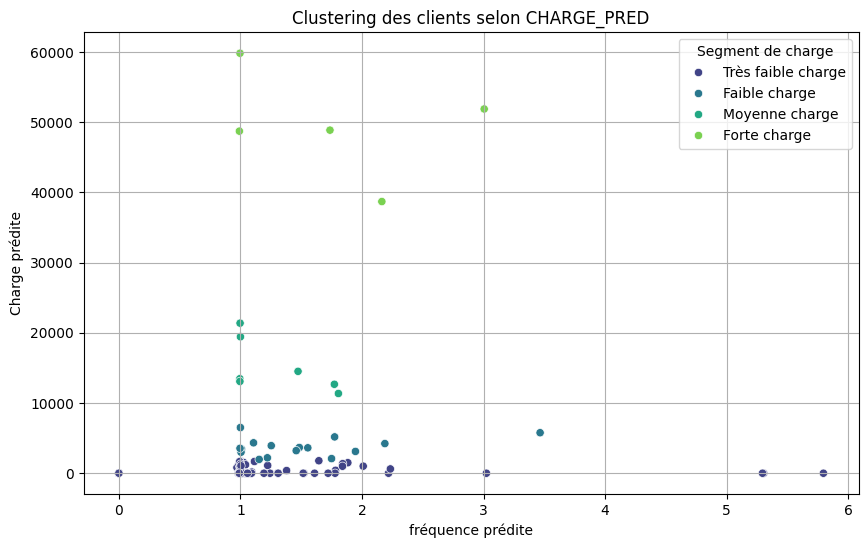

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='FREQ_PRED',
    y='CHARGE_PRED',
    hue='CHARGE_CLUSTER_LABEL',
    palette='viridis',
    data=df_test_x
)
plt.title('Clustering des clients selon CHARGE_PRED')
plt.xlabel("fréquence prédite")
plt.ylabel("Charge prédite")
plt.legend(title='Segment de charge')
plt.grid(True)
plt.show()


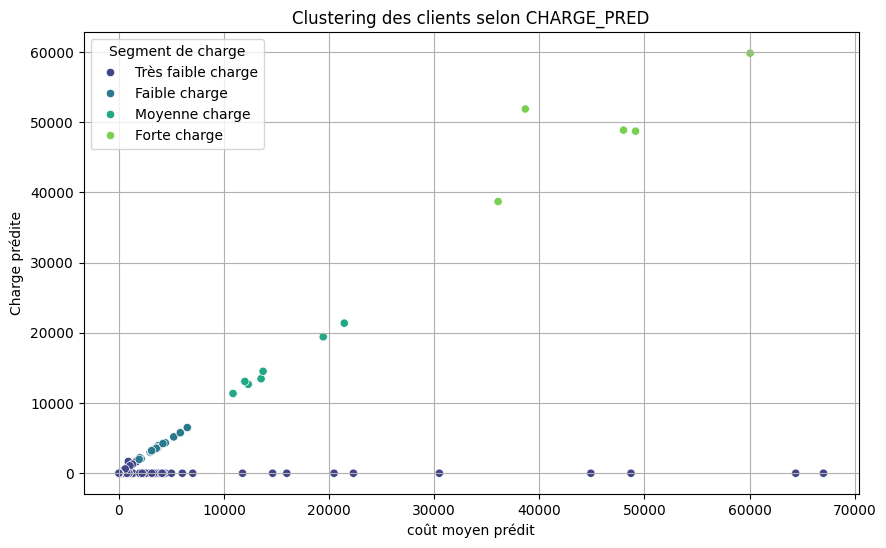

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='CM_PRED',
    y='CHARGE_PRED',
    hue='CHARGE_CLUSTER_LABEL',
    palette='viridis',
    data=df_test_x
)
plt.title('Clustering des clients selon CHARGE_PRED')
plt.xlabel("coût moyen prédit")
plt.ylabel("Charge prédite")
plt.legend(title='Segment de charge')
plt.grid(True)
plt.show()


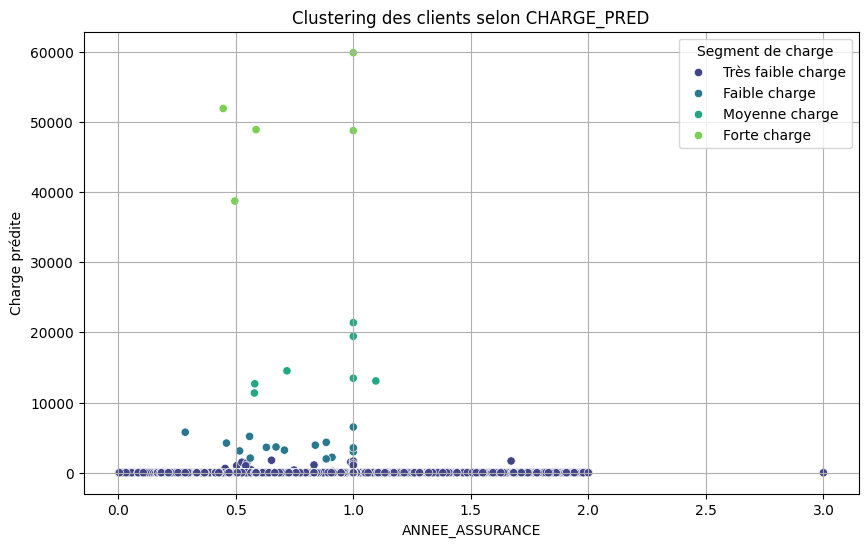

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='ANNEE_ASSURANCE',
    y='CHARGE_PRED',
    hue='CHARGE_CLUSTER_LABEL',
    palette='viridis',
    data=df_test_x
)
plt.title('Clustering des clients selon CHARGE_PRED')
plt.xlabel("ANNEE_ASSURANCE")
plt.ylabel("Charge prédite")
plt.legend(title='Segment de charge')
plt.grid(True)
plt.show()


In [37]:
!pip install plotly

In [38]:
import plotly.express as px

fig = px.scatter_3d(
    df_test_x,
    x='FREQ_PRED',
    y='CM_PRED',
    z='CHARGE_PRED',
    color='CHARGE_CLUSTER_LABEL',
    hover_name='ID',
    title="Clustering 3D des clients (Charge/FREQ/CM)",
    labels={
        'FREQ_PRED': 'Fréquence prédite',
        'CM_PRED': 'Coût moyen prédit',
        'CHARGE_PRED': 'Charge prédite'
    },
    opacity=0.7
)

fig.update_layout(
    legend_title_text='Segment de charge',
    scene=dict(
        xaxis_title='Fréquence prédite',
        yaxis_title='Coût moyen prédit',
        zaxis_title='Charge prédite'
    )
)

fig.show()


In [39]:
# Afficher quelques exemples de clients par cluster
df_test_x[['FREQ_PRED', 'CM_PRED', 'CHARGE_PRED', 'CHARGE_CLUSTER_LABEL']].groupby('CHARGE_CLUSTER_LABEL').describe()


FREQ_PRED                                          \
                         count      mean       std       min       25%   
CHARGE_CLUSTER_LABEL                                                     
Faible charge             17.0  1.492623  0.628718  0.996490  1.008581   
Forte charge               5.0  1.778677  0.849487  0.991407  0.996415   
Moyenne charge             7.0  1.291528  0.382253  0.995077  0.996392   
Très faible charge     95823.0  0.000932  0.044701  0.000000  0.000000   

                                                    CM_PRED                \
                           50%       75%       max    count          mean   
CHARGE_CLUSTER_LABEL                                                        
Faible charge         1.253601  1.749692  3.465426     17.0   3697.432696   
Forte charge          1.736608  2.163532  3.005421      5.0  46390.039844   
Moyenne charge        1.000040  1.623357  1.806079      7.0  14754.331752   
Très faible charge    0.000000  0.000000  5.796466  95823.0      4.705995   

                      ...                             CHARGE_PRED  \
                      ...           75%           max       count   
CHARGE_CLUSTER_LABEL  ...                                           
Faible charge         ...   4193.750000   6509.197266        17.0   
Forte charge          ...  49155.945312  60050.585938         5.0   
Moyenne charge        ...  16579.073730  21442.849609         7.0   
Très faible charge    ...      0.000000  67024.492188     95823.0   

                                                                             \
                              mean          std           min           25%   
CHARGE_CLUSTER_LABEL                                                          
Faible charge          3715.913819  1229.927294   1971.177153   3105.392763   
Forte charge          49608.531321  7582.997356  38704.183920  48733.558872   
Moyenne charge        15129.504567  3769.992258  11358.824429  12874.962956   
Très faible charge        0.274312    18.786753      0.000000      0.000000   

                                                                
                               50%           75%           max  
CHARGE_CLUSTER_LABEL                                            
Faible charge          3548.417631   4224.023393   6506.896554  
Forte charge          48877.384266  51892.205921  59835.323626  
Moyenne charge        13463.040224  16977.258546  21380.224309  
Très faible charge        0.000000      0.000000   1778.378645  

[4 rows x 24 columns]

In [40]:
# Création du fichier final de soumission
df_submission = df_test_x[['ID', 'FREQ_PRED', 'CM_PRED', 'CHARGE_PRED', 'CHARGE_CLUSTER_LABEL']].copy()

# Sauvegarde au format CSV
df_submission.to_csv('soumission_clients.csv', index=False)

In [42]:
df_submission

,ID,FREQ_PRED,CM_PRED,CHARGE_PRED,CHARGE_CLUSTER_LABEL
0,383611,0.0,0.0,0.0,Très faible charge
1,383612,0.0,0.0,0.0,Très faible charge
2,383613,0.0,0.0,0.0,Très faible charge
3,383614,0.0,0.0,0.0,Très faible charge
4,383615,0.0,0.0,0.0,Très faible charge
...,...,...,...,...,...
95847,479458,0.0,0.0,0.0,Très faible charge
95848,479459,0.0,0.0,0.0,Très faible charge
95849,479460,0.0,0.0,0.0,Très faible charge
95850,479461,0.0,0.0,0.0,Très faible charge


In [41]:
from google.colab import files
files.download('soumission_clients.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>